In [172]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go
import statistics
from datetime import timedelta, datetime

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from rgf.sklearn import RGFClassifier
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, recall_score, precision_score
from xgboost import XGBClassifier

from tqdm.auto import tqdm
tqdm.pandas()
sns.set_theme()

## Load Data

In [173]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
display(train_df.head())
test_df.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

In [174]:
spray_df = pd.read_csv('../data/spray.csv')
spray_df.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [175]:
weather_df = pd.read_csv('../data/weather.csv')
weather_df.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

## EDA & Preprocessing + Cleaning

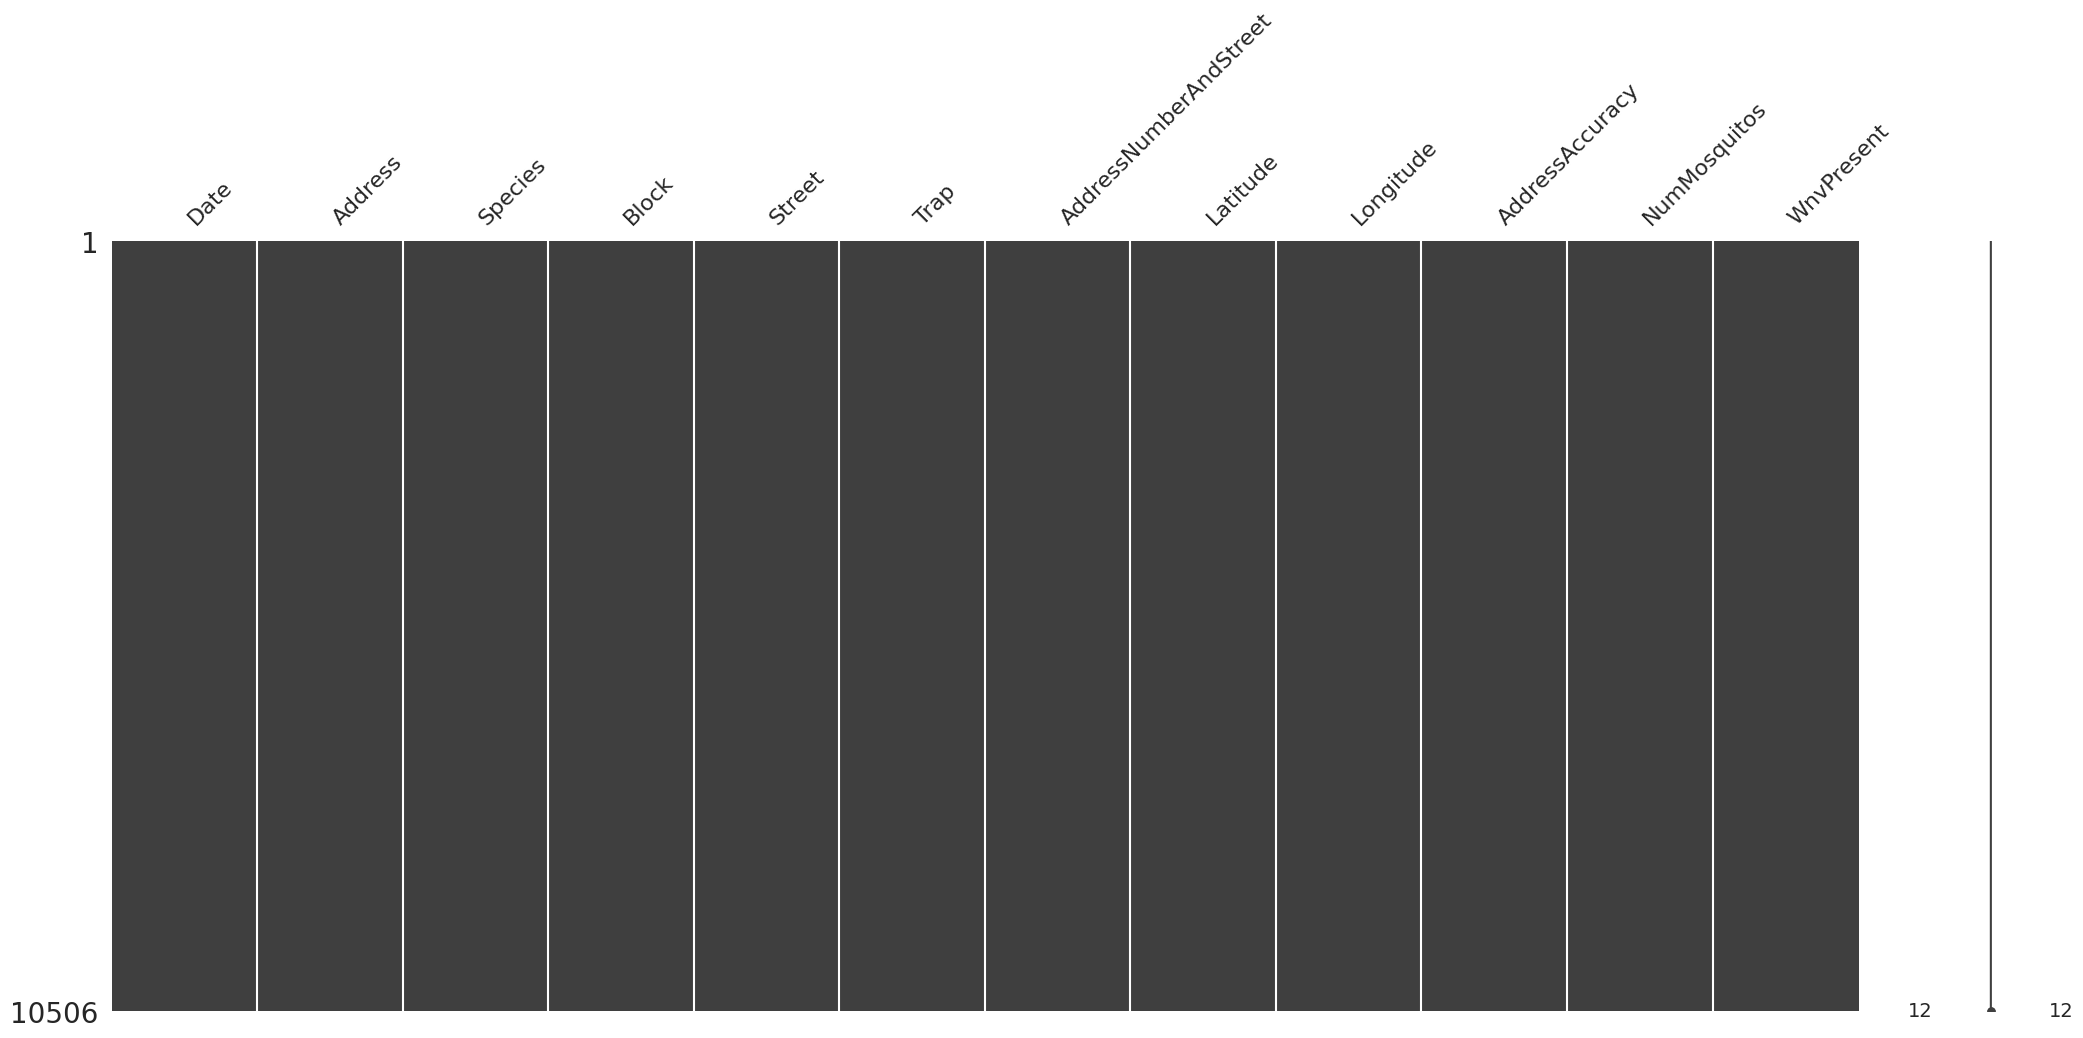

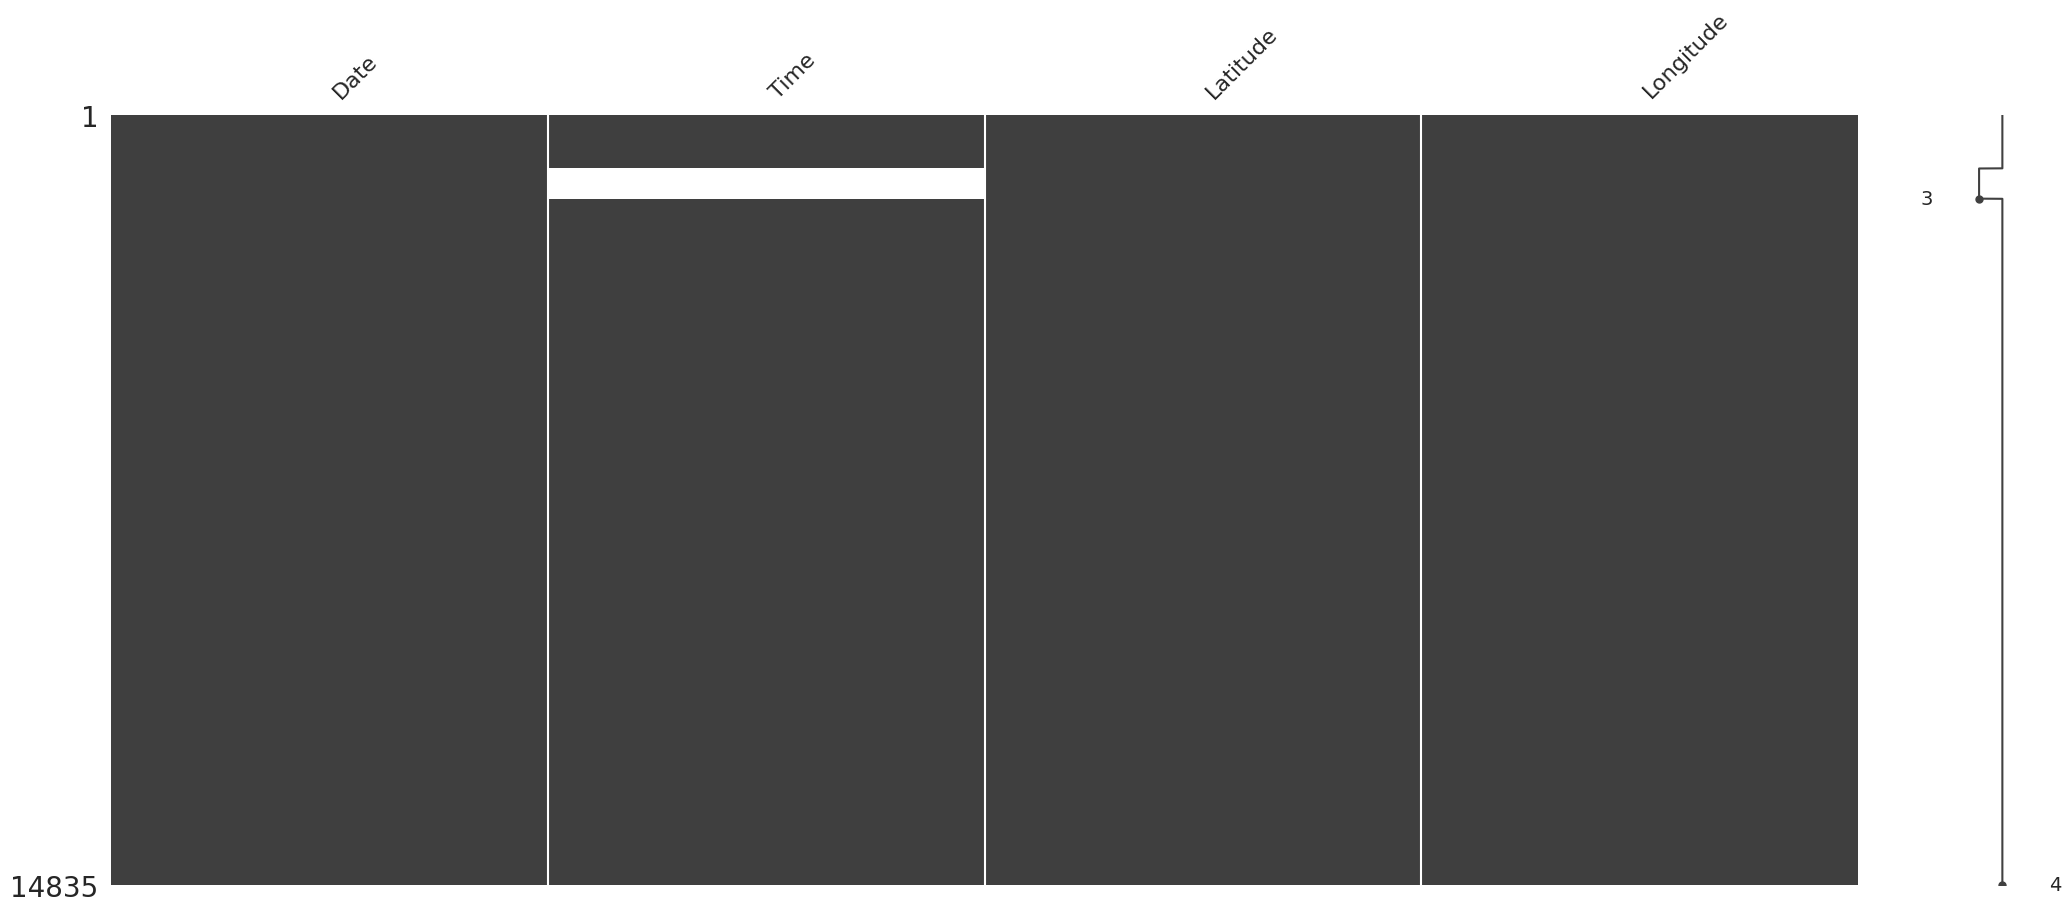

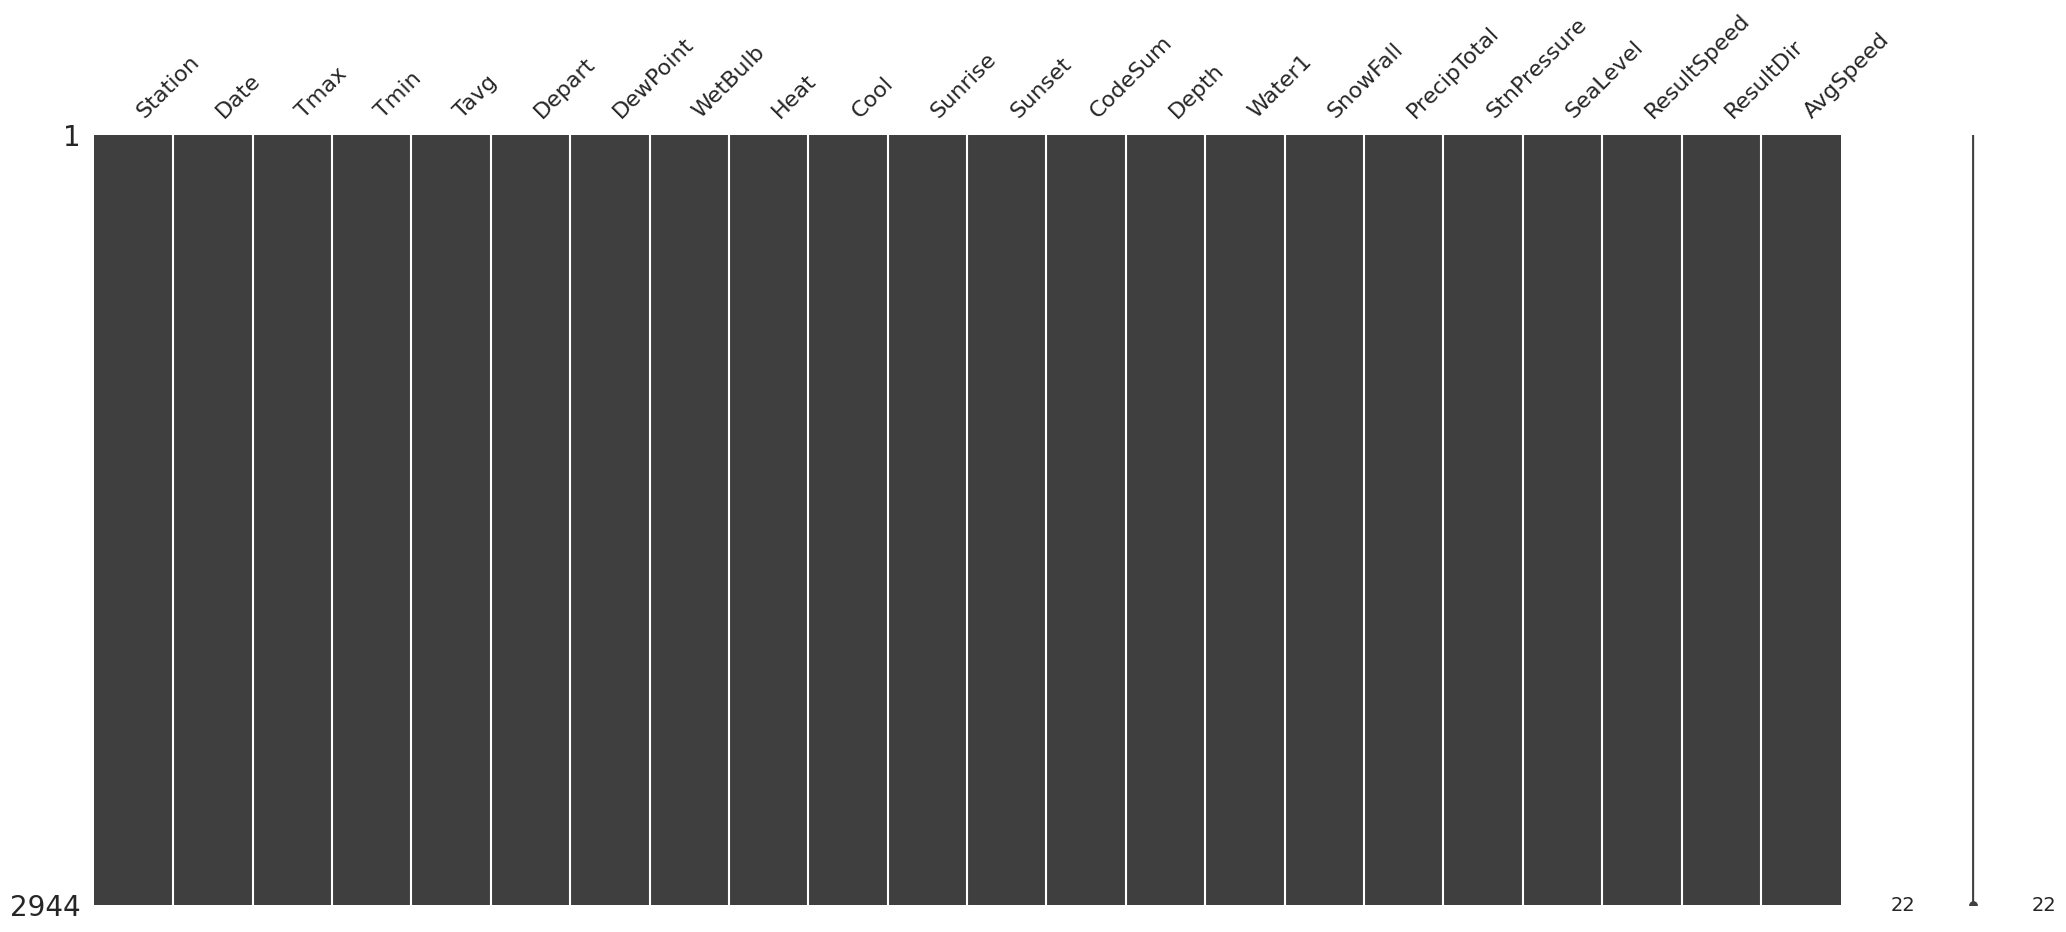

In [176]:
# Mssing values
msno.matrix(train_df)
msno.matrix(spray_df)
msno.matrix(weather_df);

In [177]:
# Spray missing values
display(spray_df.isna().sum())
spray_df.shape

Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64

(14835, 4)

### Spray data cleaning

In [178]:
# Display spray data
spray_df.head()

Date        Time   Latitude  Longitude
0  2011-08-29  6:56:58 PM  42.391623 -88.089163
1  2011-08-29  6:57:08 PM  42.391348 -88.089163
2  2011-08-29  6:57:18 PM  42.391022 -88.089157
3  2011-08-29  6:57:28 PM  42.390637 -88.089158
4  2011-08-29  6:57:38 PM  42.390410 -88.088858

In [179]:
# Find incorrect format and values in spray data
display(spray_df.info())
for col in spray_df:
    print(col)
    print(spray_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       14835 non-null  object 
 1   Time       14251 non-null  object 
 2   Latitude   14835 non-null  float64
 3   Longitude  14835 non-null  float64
dtypes: float64(2), object(2)
memory usage: 463.7+ KB


None

Date
['2011-08-29' '2011-09-07' '2013-07-17' '2013-07-25' '2013-08-08'
 '2013-08-15' '2013-08-16' '2013-08-22' '2013-08-29' '2013-09-05']
Time
['6:56:58 PM' '6:57:08 PM' '6:57:18 PM' ... '8:04:01 PM' '8:04:11 PM'
 '8:04:21 PM']
Latitude
[42.39162333 42.39134833 42.39102167 ... 42.00602167 42.00545333
 42.004805  ]
Longitude
[-88.08916333 -88.08915667 -88.08915833 ... -87.81739167 -87.81742333
 -87.81746   ]


In [180]:
# Drop 'Time' column
spray_df.drop(columns='Time', inplace=True)

In [181]:
# Convert date to datetime
spray_df['Date'] = pd.to_datetime(spray_df['Date'])
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Latitude   14835 non-null  float64       
 2   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 347.8 KB


### Weather data cleaning

In [182]:
# Display weather data
weather_df.head()

Station        Date  Tmax  Tmin Tavg Depart  DewPoint WetBulb Heat Cool  \
0        1  2007-05-01    83    50   67     14        51      56    0    2   
1        2  2007-05-01    84    52   68      M        51      57    0    3   
2        1  2007-05-02    59    42   51     -3        42      47   14    0   
3        2  2007-05-02    60    43   52      M        42      47   13    0   
4        1  2007-05-03    66    46   56      2        40      48    9    0   

   ... CodeSum Depth Water1 SnowFall PrecipTotal StnPressure SeaLevel  \
0  ...             0      M      0.0        0.00       29.10    29.82   
1  ...             M      M        M        0.00       29.18    29.82   
2  ...      BR     0      M      0.0        0.00       29.38    30.09   
3  ...   BR HZ     M      M        M        0.00       29.44    30.08   
4  ...             0      M      0.0        0.00       29.39    30.12   

  ResultSpeed ResultDir  AvgSpeed  
0         1.7        27       9.2  
1         2.7        25       9.6  
2        13.0         4      13.4  
3        13.3         2      13.4  
4        11.7         7      11.9  

[5 rows x 22 columns]

In [183]:
# Find incorrect format and values in weather data
display(weather_df.info())
for col in weather_df:
    print(col)
    print(weather_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   object 
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  CodeSum      2944 non-null   object 
 13  Depth        2944 non-null   object 
 14  Water1       2944 non-null   object 
 15  SnowFall     2944 non-null   object 
 16  PrecipTotal  2944 non-null   object 
 17  StnPressure  2944 non-null   object 
 18  SeaLevel     2944 non-null   object 
 19  Result

None

Station
[1 2]
Date
['2007-05-01' '2007-05-02' '2007-05-03' ... '2014-10-29' '2014-10-30'
 '2014-10-31']
Tmax
[ 83  84  59  60  66  67  78  68  82  80  77  76  70  73  64  65  69  90
  62  61  71  79  87  89  88  75  85  86  81  72  63  91  92  93  74  94
  54  53  56  57  58  55  50  95  52  47  45  51  48  44  49  46  96  99
 100 101  97  98 102 103 104  42  41]
Tmin
[50 52 42 43 46 48 49 51 53 54 47 60 61 63 56 59 44 57 45 55 66 65 70 68
 62 67 64 58 71 69 73 75 72 74 39 41 40 37 34 38 35 36 33 31 32 76 77 29
 78 79 80 81 82 83]
Tavg
['67' '68' '51' '52' '56' '58' 'M' '60' '59' '65' '70' '69' '71' '61' '55'
 '57' '73' '72' '53' '62' '63' '74' '75' '78' '76' '77' '66' '80' '64'
 '81' '82' '79' '85' '84' '83' '50' '49' '46' '48' '45' '54' '47' '44'
 '40' '41' '38' '39' '42' '37' '43' '86' '87' '89' '92' '88' '91' '93'
 '94' '90' '36']
Depart
['14' 'M' '-3' ' 2' ' 4' ' 5' '10' '12' '13' '-2' '15' '11' '-4' '-6' ' 8'
 '-5' ' 1' ' 9' ' 6' '-9' '-8' ' 3' ' 0' '-1' '-7' ' 7' '-14' '18' '16'

In [184]:
# Number of incorrect format and values in weather data
for col in weather_df:
    if weather_df[(weather_df[col] == 'M') | (weather_df[col] == '  T') | (weather_df[col] == '-')].shape[0] != 0:
        print(col)
        print('M', weather_df[(weather_df[col] == 'M')].shape)
        print('T', weather_df[(weather_df[col] == '  T')].shape)
        print('-', weather_df[(weather_df[col] == '-')].shape)

Tavg
M (11, 22)
T (0, 22)
- (0, 22)
Depart
M (1472, 22)
T (0, 22)
- (0, 22)
WetBulb
M (4, 22)
T (0, 22)
- (0, 22)
Heat
M (11, 22)
T (0, 22)
- (0, 22)
Cool
M (11, 22)
T (0, 22)
- (0, 22)
Sunrise
M (0, 22)
T (0, 22)
- (1472, 22)
Sunset
M (0, 22)
T (0, 22)
- (1472, 22)
Depth
M (1472, 22)
T (0, 22)
- (0, 22)
Water1
M (2944, 22)
T (0, 22)
- (0, 22)
SnowFall
M (1472, 22)
T (12, 22)
- (0, 22)
PrecipTotal
M (2, 22)
T (318, 22)
- (0, 22)
StnPressure
M (4, 22)
T (0, 22)
- (0, 22)
SeaLevel
M (9, 22)
T (0, 22)
- (0, 22)
AvgSpeed
M (3, 22)
T (0, 22)
- (0, 22)


In [185]:
# Drop column with a lot of missing/unusable values in weather
weather_df.drop(columns=['Depart', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall', 'CodeSum'], inplace=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   DewPoint     2944 non-null   int64  
 6   WetBulb      2944 non-null   object 
 7   Heat         2944 non-null   object 
 8   Cool         2944 non-null   object 
 9   PrecipTotal  2944 non-null   object 
 10  StnPressure  2944 non-null   object 
 11  SeaLevel     2944 non-null   object 
 12  ResultSpeed  2944 non-null   float64
 13  ResultDir    2944 non-null   int64  
 14  AvgSpeed     2944 non-null   object 
dtypes: float64(1), int64(5), object(9)
memory usage: 345.1+ KB


In [186]:
# Convert date to datetime
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [187]:
# Replace PrecipTotal 'T' (Trace) with very small value
weather_df['PrecipTotal'] = weather_df['PrecipTotal'].progress_map(lambda x: 0.001 if x == '  T' else x)

  0%|          | 0/2944 [00:00<?, ?it/s]

In [188]:
# Replace 'M' value with NaN, prepare for imputer
weather_df.replace('M', np.nan, inplace=True)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   object        
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2940 non-null   object        
 7   Heat         2933 non-null   object        
 8   Cool         2933 non-null   object        
 9   PrecipTotal  2942 non-null   object        
 10  StnPressure  2940 non-null   object        
 11  SeaLevel     2935 non-null   object        
 12  ResultSpeed  2944 non-null   float64       
 13  ResultDir    2944 non-null   int64         
 14  AvgSpeed     2941 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(8)
m

In [189]:
# Convert all object field to float
weather_df[['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']] = weather_df[['Tavg', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']].astype(float)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2933 non-null   float64       
 5   DewPoint     2944 non-null   int64         
 6   WetBulb      2940 non-null   float64       
 7   Heat         2933 non-null   float64       
 8   Cool         2933 non-null   float64       
 9   PrecipTotal  2942 non-null   float64       
 10  StnPressure  2940 non-null   float64       
 11  SeaLevel     2935 non-null   float64       
 12  ResultSpeed  2944 non-null   float64       
 13  ResultDir    2944 non-null   int64         
 14  AvgSpeed     2941 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(5)
memory usage

In [190]:
# Separate weather into 2 df (station 1 and 2)
weather_df_station_1 = weather_df[weather_df['Station'] == 1].drop(columns='Station')
weather_df_station_2 = weather_df[weather_df['Station'] == 2].drop(columns='Station')

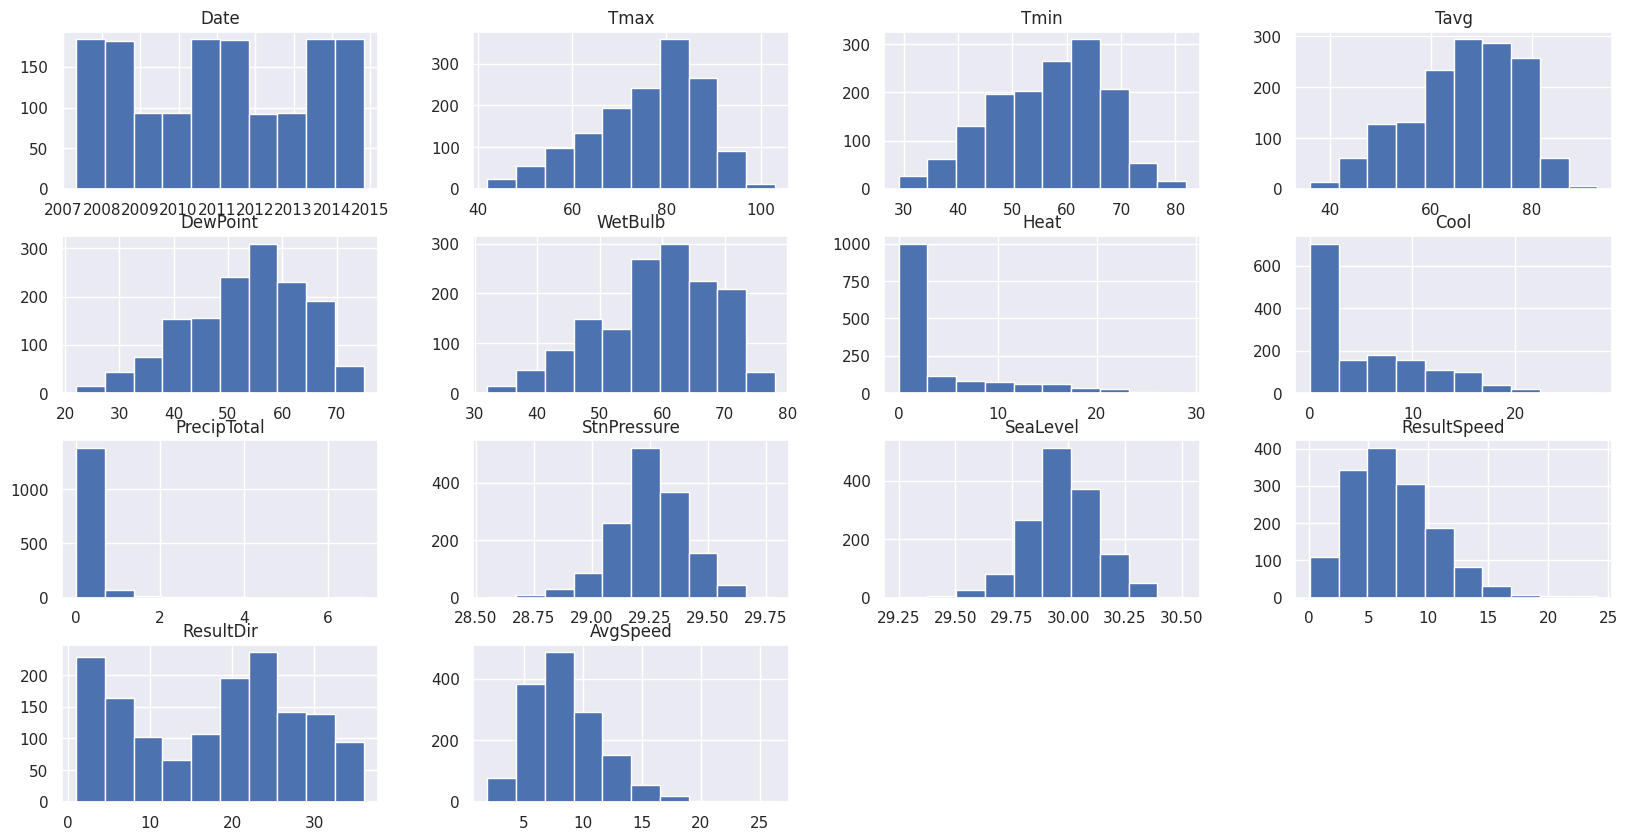

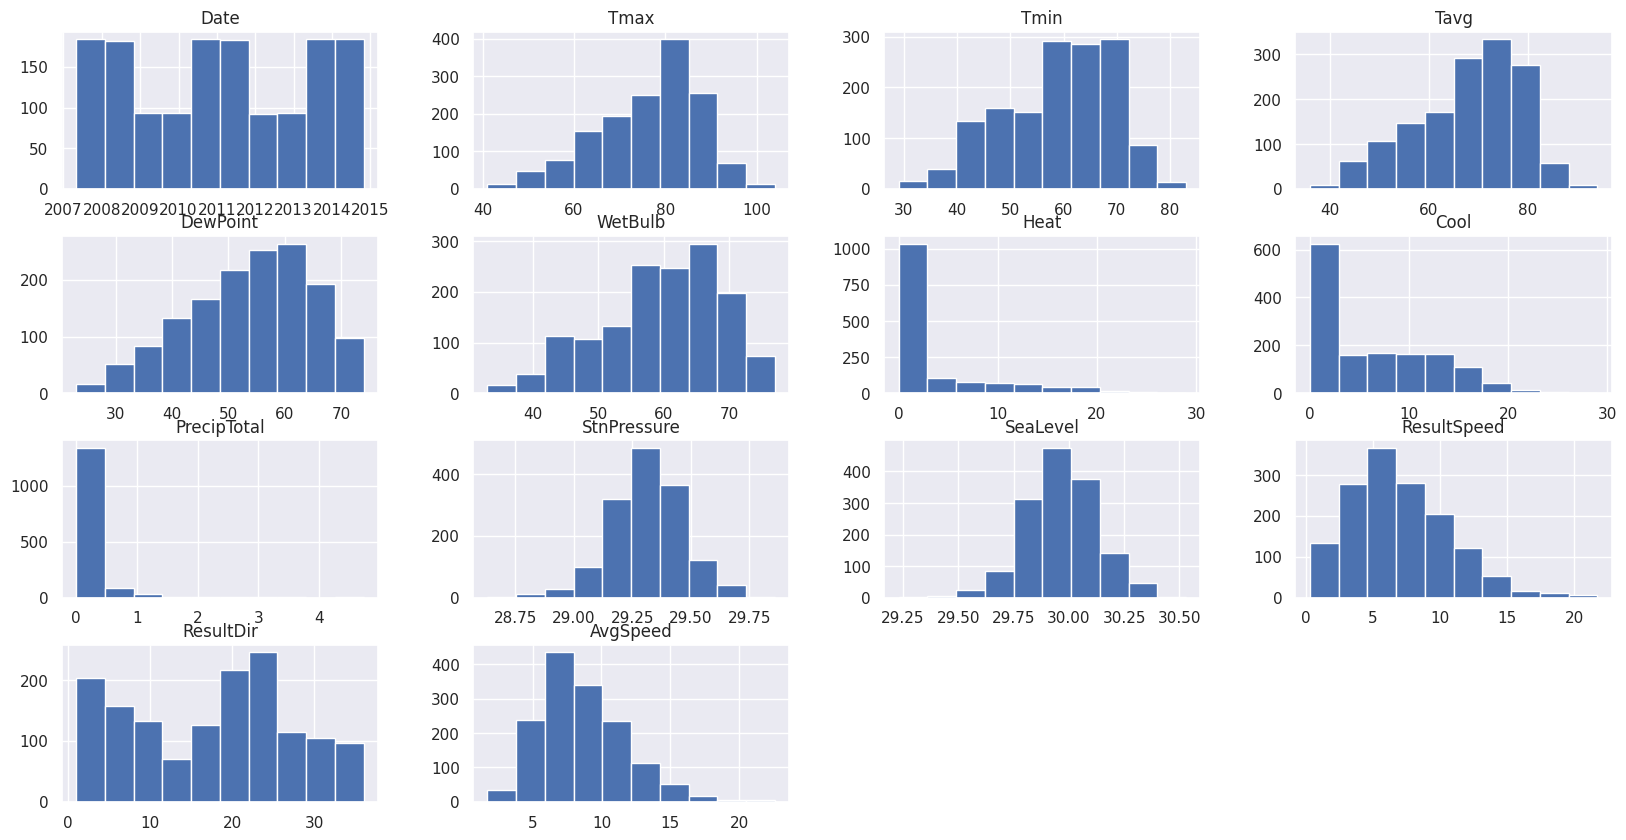

In [191]:
# Data from 2 stations is a little bit different (not that much)
weather_df_station_1.hist(figsize=(20, 10))
weather_df_station_2.hist(figsize=(20, 10));

In [192]:
# Create new weather df, average data from 2 stations. If one missing, using the other one instead
weather_df_avg = (weather_df_station_1.set_index('Date') + weather_df_station_2.set_index('Date')) / 2
weather_df_avg = weather_df_avg.combine_first(weather_df_station_1.set_index('Date')).combine_first(weather_df_station_2.set_index('Date'))
weather_df_avg.reset_index(inplace=True)

display(weather_df_avg.info())
weather_df_avg.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1472 non-null   datetime64[ns]
 1   Tmax         1472 non-null   float64       
 2   Tmin         1472 non-null   float64       
 3   Tavg         1472 non-null   float64       
 4   DewPoint     1472 non-null   float64       
 5   WetBulb      1472 non-null   float64       
 6   Heat         1472 non-null   float64       
 7   Cool         1472 non-null   float64       
 8   PrecipTotal  1472 non-null   float64       
 9   StnPressure  1471 non-null   float64       
 10  SeaLevel     1472 non-null   float64       
 11  ResultSpeed  1472 non-null   float64       
 12  ResultDir    1472 non-null   float64       
 13  AvgSpeed     1472 non-null   float64       
dtypes: datetime64[ns](1), float64(13)
memory usage: 161.1 KB


None

Date  Tmax  Tmin  Tavg  DewPoint  WetBulb  Heat  Cool  PrecipTotal  \
0 2007-05-01  83.5  51.0  67.5      51.0     56.5   0.0   2.5       0.0000   
1 2007-05-02  59.5  42.5  51.5      42.0     47.0  13.5   0.0       0.0000   
2 2007-05-03  66.5  47.0  57.0      40.0     49.0   8.0   0.0       0.0000   
3 2007-05-04  72.0  50.0  58.0      41.5     50.0   7.0   0.0       0.0005   
4 2007-05-05  66.0  53.5  60.0      38.5     49.5   5.0   0.0       0.0010   

   StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0       29.140    29.820         2.20       26.0      9.40  
1       29.410    30.085        13.15        3.0     13.40  
2       29.425    30.120        12.30        6.5     12.55  
3       29.335    30.045        10.25        7.5     10.60  
4       29.430    30.095        11.45        7.0     11.75

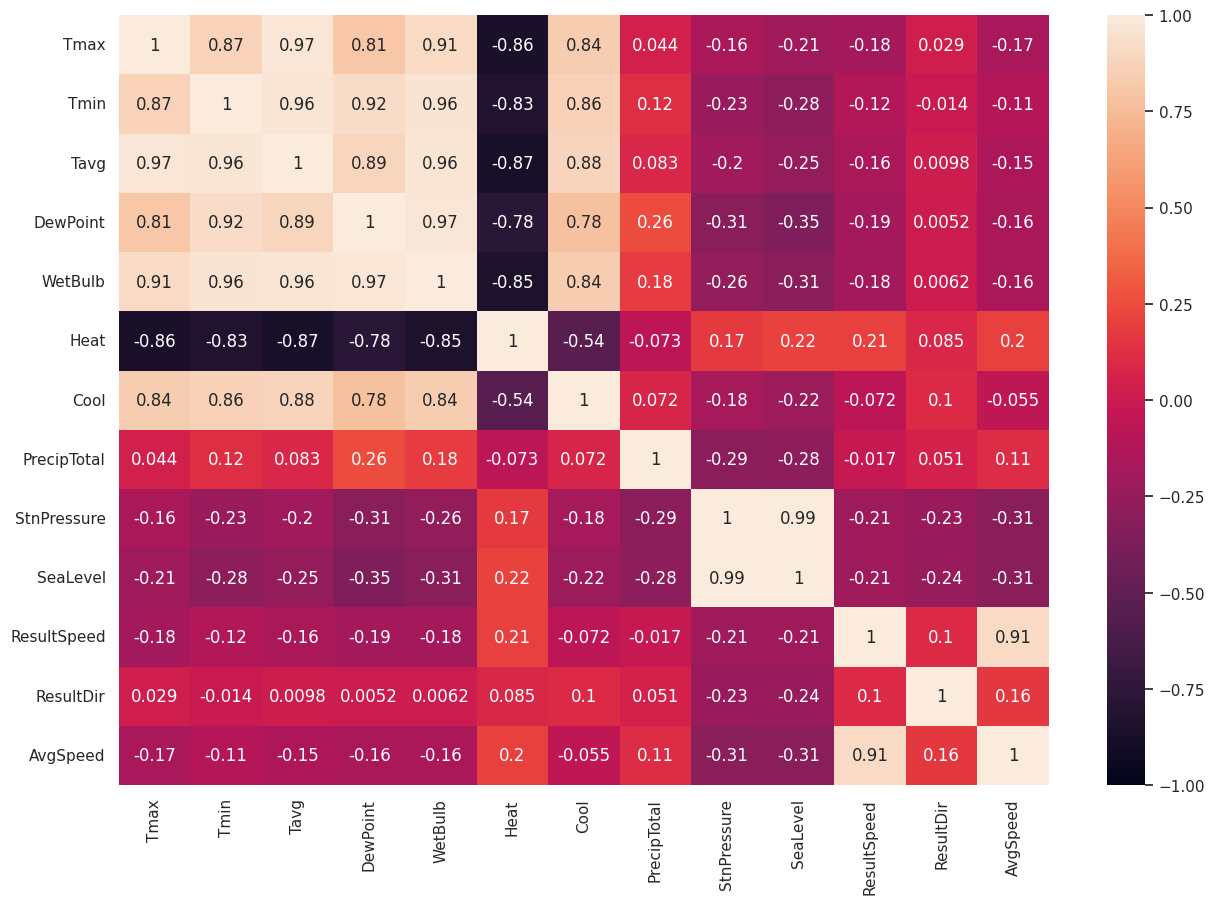

In [193]:
# Correlation
plt.figure(figsize=(15, 10))
sns.heatmap(weather_df_avg.corr(numeric_only=True), annot=True, vmin=-1, vmax=1);

In [194]:
# Drop Tmin, Tmax, Heat, Cool, WetBulb, DewPoint (strong correlation with Tavg) ResultSpeed (Strong correlation with AvgSpeed) SeaLevel (Strong correlation with StnPressure)
# weather_df_avg.drop(columns=['Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel'], inplace=True)

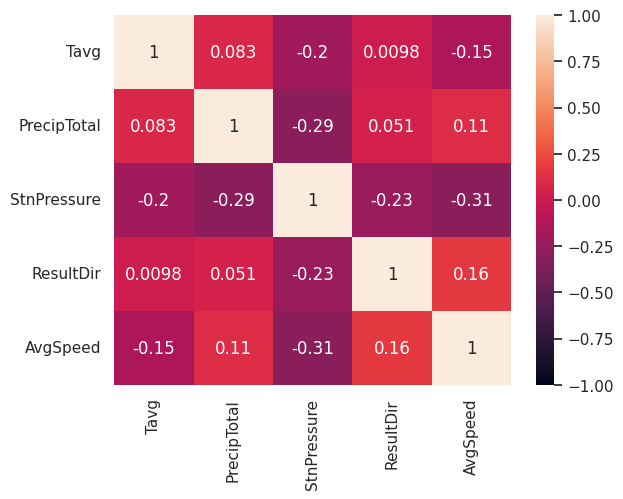

In [195]:
# Recheck Correlation
sns.heatmap(weather_df_avg.drop(columns=['Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel']).corr(numeric_only=True), annot=True, vmin=-1, vmax=1);

In [196]:
# Extract weeknum and year
# weather_df_avg['weeknum'] = weather_df_avg['Date'].dt.strftime("%U").astype(int)
# weather_df_avg['year'] = weather_df_avg['Date'].dt.year

In [197]:
# Set date as index for timeseries processing
weather_df_avg.set_index('Date', inplace=True)
weather_df_avg.head()

Tmax  Tmin  Tavg  DewPoint  WetBulb  Heat  Cool  PrecipTotal  \
Date                                                                       
2007-05-01  83.5  51.0  67.5      51.0     56.5   0.0   2.5       0.0000   
2007-05-02  59.5  42.5  51.5      42.0     47.0  13.5   0.0       0.0000   
2007-05-03  66.5  47.0  57.0      40.0     49.0   8.0   0.0       0.0000   
2007-05-04  72.0  50.0  58.0      41.5     50.0   7.0   0.0       0.0005   
2007-05-05  66.0  53.5  60.0      38.5     49.5   5.0   0.0       0.0010   

            StnPressure  SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
Date                                                                 
2007-05-01       29.140    29.820         2.20       26.0      9.40  
2007-05-02       29.410    30.085        13.15        3.0     13.40  
2007-05-03       29.425    30.120        12.30        6.5     12.55  
2007-05-04       29.335    30.045        10.25        7.5     10.60  
2007-05-05       29.430    30.095        11.45        7.0     11.75

In [198]:
# Check rolling average result
weather_df_avg.rolling(14).mean().reset_index()

Date       Tmax       Tmin       Tavg   DewPoint    WetBulb  \
0    2007-05-01        NaN        NaN        NaN        NaN        NaN   
1    2007-05-02        NaN        NaN        NaN        NaN        NaN   
2    2007-05-03        NaN        NaN        NaN        NaN        NaN   
3    2007-05-04        NaN        NaN        NaN        NaN        NaN   
4    2007-05-05        NaN        NaN        NaN        NaN        NaN   
...         ...        ...        ...        ...        ...        ...   
1467 2014-10-27  62.000000  46.285714  54.464286  44.321429  49.464286   
1468 2014-10-28  62.071429  45.821429  54.250000  42.964286  48.642857   
1469 2014-10-29  61.535714  44.857143  53.500000  41.607143  47.821429   
1470 2014-10-30  61.178571  43.642857  52.714286  40.464286  47.035714   
1471 2014-10-31  60.142857  42.571429  51.678571  39.035714  45.857143   

           Heat      Cool  PrecipTotal  StnPressure   SeaLevel  ResultSpeed  \
0           NaN       NaN          NaN          NaN        NaN          NaN   
1           NaN       NaN          NaN          NaN        NaN          NaN   
2           NaN       NaN          NaN          NaN        NaN          NaN   
3           NaN       NaN          NaN          NaN        NaN          NaN   
4           NaN       NaN          NaN          NaN        NaN          NaN   
...         ...       ...          ...          ...        ...          ...   
1467  10.607143  0.071429     0.072286    29.228571  29.925714     7.042857   
1468  10.821429  0.071429     0.008036    29.252143  29.947500     7.882143   
1469  11.571429  0.071429     0.003750    29.274643  29.970357     7.850000   
1470  12.357143  0.071429     0.003714    29.297500  29.993571     7.903571   
1471  13.392857  0.071429     0.005821    29.332857  30.030000     8.707143   

      ResultDir  AvgSpeed  
0           NaN       NaN  
1           NaN       NaN  
2           NaN       NaN  
3           NaN       NaN  
4           NaN       NaN  
...         ...       ...  
1467  22.178571  9.046429  
1468  23.250000  9.453571  
1469  22.821429  9.428571  
1470  22.750000  9.292857  
1471  23.142857  9.992857  

[1472 rows x 14 columns]

In [199]:
# Check resampling average result
weather_df_avg.resample('2W').mean().reset_index()

Date       Tmax       Tmin       Tavg   DewPoint    WetBulb  \
0   2007-05-06  69.250000  49.083333  58.916667  40.500000  49.666667   
1   2007-05-20  74.750000  50.464286  62.785714  43.321429  52.607143   
2   2007-06-03  80.750000  59.785714  70.535714  53.964286  61.035714   
3   2007-06-17  82.607143  60.964286  72.000000  54.035714  61.607143   
4   2007-07-01  79.857143  63.250000  71.785714  57.678571  63.464286   
..         ...        ...        ...        ...        ...        ...   
192 2014-09-14  75.607143  58.500000  67.250000  55.464286  60.321429   
193 2014-09-28  73.642857  53.250000  63.714286  50.892857  56.428571   
194 2014-10-12  64.142857  46.142857  55.428571  43.071429  49.214286   
195 2014-10-26  61.357143  46.642857  54.321429  44.892857  49.642857   
196 2014-11-09  58.800000  41.000000  50.200000  37.000000  44.500000   

          Heat      Cool  PrecipTotal  StnPressure   SeaLevel  ResultSpeed  \
0     6.500000  0.416667     0.000250    29.389167  30.075000    10.575000   
1     4.321429  2.107143     0.054357    29.380714  30.072857     8.182143   
2     0.821429  6.357143     0.101214    29.326429  30.014643     7.421429   
3     1.035714  8.035714     0.055821    29.241071  29.917500     7.117857   
4     0.107143  6.892857     0.102643    29.367500  30.045000     7.628571   
..         ...       ...          ...          ...        ...          ...   
192   3.500000  5.750000     0.177179    29.346071  30.028571     7.110714   
193   2.607143  1.321429     0.008714    29.440000  30.131071     4.400000   
194  10.214286  0.642857     0.105214    29.203571  29.897500     8.432143   
195  10.678571  0.000000     0.110143    29.231429  29.930357     6.703571   
196  15.000000  0.200000     0.012200    29.286000  29.975000    12.680000   

     ResultDir   AvgSpeed  
0    10.083333  12.075000  
1    15.535714   9.917857  
2    16.964286   8.889286  
3    14.928571   8.800000  
4    12.607143   9.032143  
..         ...        ...  
192  24.714286   9.075000  
193  17.892857   6.167857  
194  18.714286   9.675000  
195  21.857143   8.742857  
196  26.300000  13.310000  

[197 rows x 14 columns]

### Train data cleaning

In [200]:
# Display train data
train_df.head()

Date                                            Address  \
0  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1  2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2  2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4  2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  
0             1           0  
1             1           0  
2             1           0  
3             1           0  
4             4           0

In [201]:
# Find incorrect format and values in train data
display(train_df.info())
for col in train_df:
    print(col)
    print(train_df[col].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    10506 non-null  object 
 1   Address                 10506 non-null  object 
 2   Species                 10506 non-null  object 
 3   Block                   10506 non-null  int64  
 4   Street                  10506 non-null  object 
 5   Trap                    10506 non-null  object 
 6   AddressNumberAndStreet  10506 non-null  object 
 7   Latitude                10506 non-null  float64
 8   Longitude               10506 non-null  float64
 9   AddressAccuracy         10506 non-null  int64  
 10  NumMosquitos            10506 non-null  int64  
 11  WnvPresent              10506 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 985.1+ KB


None

Date
['2007-05-29' '2007-06-05' '2007-06-26' '2007-06-29' '2007-07-02'
 '2007-07-11' '2007-07-18' '2007-07-19' '2007-07-25' '2007-07-27'
 '2007-08-01' '2007-08-02' '2007-08-03' '2007-08-07' '2007-08-08'
 '2007-08-09' '2007-08-15' '2007-08-16' '2007-08-17' '2007-08-21'
 '2007-08-22' '2007-08-24' '2007-08-28' '2007-09-04' '2007-09-05'
 '2007-09-06' '2007-09-12' '2007-09-18' '2007-09-19' '2007-09-24'
 '2007-09-25' '2007-10-04' '2007-10-09' '2009-05-28' '2009-06-02'
 '2009-06-03' '2009-06-05' '2009-06-12' '2009-06-15' '2009-06-19'
 '2009-06-22' '2009-06-26' '2009-06-29' '2009-07-06' '2009-07-10'
 '2009-07-13' '2009-07-17' '2009-07-24' '2009-07-27' '2009-07-31'
 '2009-08-07' '2009-08-13' '2009-08-25' '2009-08-27' '2009-09-03'
 '2009-09-14' '2009-09-17' '2009-09-25' '2009-10-01' '2011-06-10'
 '2011-06-17' '2011-06-24' '2011-06-30' '2011-07-11' '2011-07-15'
 '2011-07-25' '2011-07-29' '2011-08-05' '2011-08-12' '2011-08-19'
 '2011-08-26' '2011-09-01' '2011-09-02' '2011-09-12' '2011-09-16'
 '201

In [202]:
# Convert Date to datetime
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [203]:
# col = list(train_df.drop(columns=['NumMosquitos', 'WnvPresent']).columns)
# grouped_df = train_df.copy()
# grouped_df['Count'] = train_df.groupby(col, as_index=False)['NumMosquitos'].transform('count')
# grouped_df

In [204]:
# grouped_df[grouped_df['Date'].dt.month == 8]['Date'].unique()

In [205]:
# grouped_df[grouped_df['Date'] == '2009-08-27']

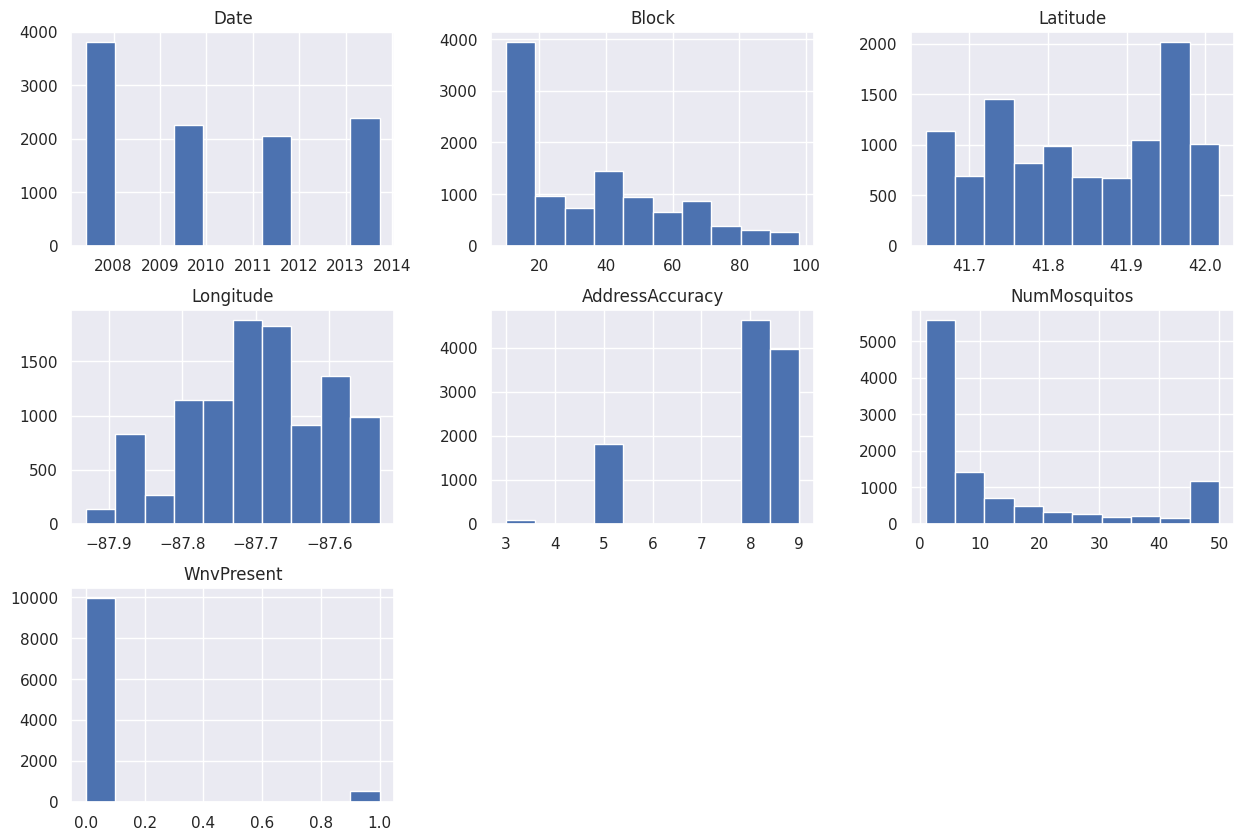

In [206]:
# Train data distribution
train_df.hist(figsize=(15, 10));

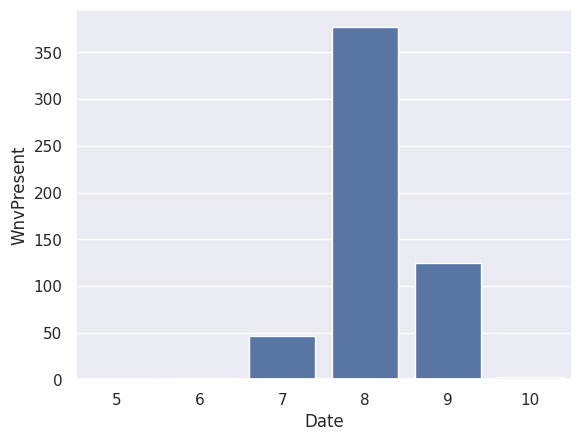

In [207]:
# Target variable (west nile virus present) group by month
sns.barplot(train_df.groupby(train_df['Date'].dt.month)['WnvPresent'].sum());

In [208]:
# Proportion of target variable classes
train_df[train_df['Date'].dt.month.isin([8, 9])]['WnvPresent'].value_counts(normalize=True)

WnvPresent
0    0.915899
1    0.084101
Name: proportion, dtype: float64

In [209]:
# Check test data features (no NumMosquitos, cannot be used as a predictor)
test_df.head()

Id        Date                                            Address  \
0   1  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1   2  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2   3  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
3   4  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   
4   5  2008-06-11  4100 North Oak Park Avenue, Chicago, IL 60634,...   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2           CULEX PIPIENS     41   N OAK PARK AVE  T002   
3        CULEX SALINARIUS     41   N OAK PARK AVE  T002   
4         CULEX TERRITANS     41   N OAK PARK AVE  T002   

              AddressNumberAndStreet  Latitude  Longitude  AddressAccuracy  
0  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
1  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
2  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
3  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9  
4  4100  N OAK PARK AVE, Chicago, IL  41.95469 -87.800991                9

Species                 WnvPresent
CULEX ERRATICUS         0                1
CULEX PIPIENS           0             2459
                        1              240
CULEX PIPIENS/RESTUANS  0             4490
                        1              262
CULEX RESTUANS          0             2691
                        1               49
CULEX SALINARIUS        0               86
CULEX TARSALIS          0                6
CULEX TERRITANS         0              222
Name: count, dtype: int64

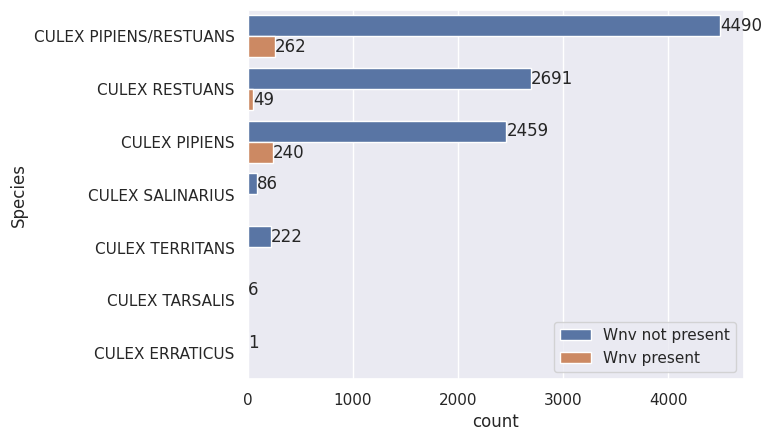

In [210]:
# WnvPresent in each species
display(train_df.groupby('Species')['WnvPresent'].value_counts())
ax = sns.countplot(train_df, y='Species', hue='WnvPresent')
for container in ax.containers:
    plt.bar_label(container)
plt.legend(['Wnv not present', 'Wnv present'], loc='lower right');

In [211]:
# Number of blocks per trap, there are 1 trap that located in 2 block
print(train_df[['Trap', 'Block']].drop_duplicates().groupby('Trap').count().value_counts())
display(train_df[['Trap', 'Block']].drop_duplicates().groupby('Trap').count().sort_values(by='Block', ascending=False))

display(train_df[train_df['Trap'] == 'T035'][['Latitude', 'Longitude', 'Block']].value_counts())

Block
1        135
2          1
Name: count, dtype: int64


Block
Trap       
T035      2
T138      1
T141      1
T142      1
T143      1
...     ...
T067      1
T069      1
T070      1
T071      1
T061      1

[136 rows x 1 columns]

Latitude   Longitude   Block
41.763733  -87.742302  51       45
41.836644  -87.677737  30       27
Name: count, dtype: int64

In [212]:
# Check block location, is that unique, no overlap ?
print(train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby(['Latitude', 'Longitude']).count().value_counts())
train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby(['Latitude', 'Longitude']).count().sort_values(by='Block', ascending=False)

Block
1        138
Name: count, dtype: int64


Block
Latitude  Longitude        
42.017430 -87.687769      1
41.644612 -87.604498      1
41.984809 -87.728492      1
41.986921 -87.689778      1
41.987280 -87.666066      1
...                     ...
41.680946 -87.535198      1
41.682587 -87.707973      1
41.686398 -87.531635      1
41.688324 -87.676709      1
41.692555 -87.598865      1

[138 rows x 1 columns]

In [213]:
# Check block location, is that unique, no overlap ?
print(train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby('Block').count().value_counts())
train_df[['Latitude', 'Longitude', 'Block']].drop_duplicates().groupby('Block').count().sort_values(by='Block', ascending=False)

Latitude  Longitude
1         1            27
2         2            20
3         3             9
4         4             5
9         9             2
6         6             1
Name: count, dtype: int64


Latitude  Longitude
Block                     
98            1          1
96            2          2
93            1          1
91            2          2
90            1          1
...         ...        ...
14            1          1
13            4          4
12            2          2
11            9          9
10            9          9

[64 rows x 2 columns]

### Merge train with weather for more EDA

In [214]:
train_and_weather = train_df.merge(
    right=weather_df_avg,
    on='Date'
)

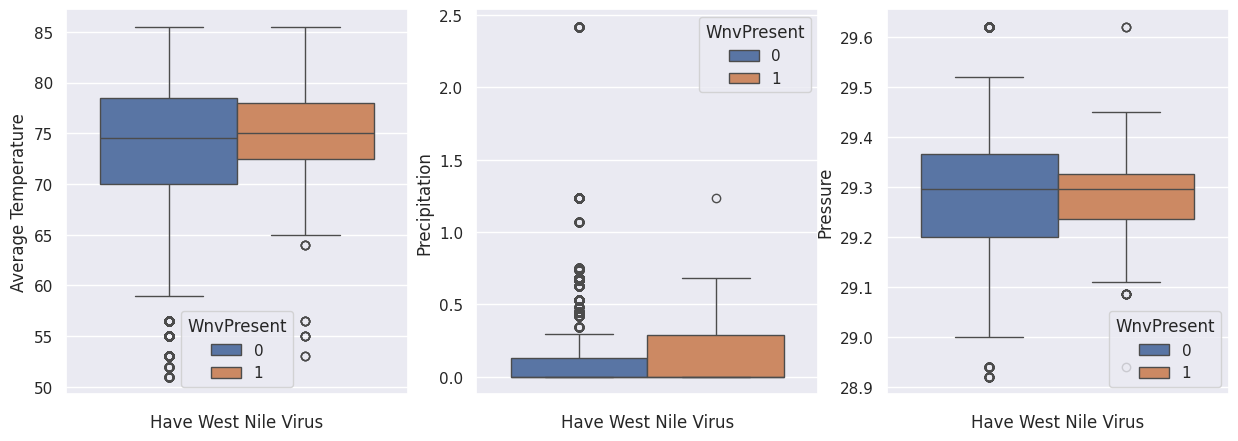

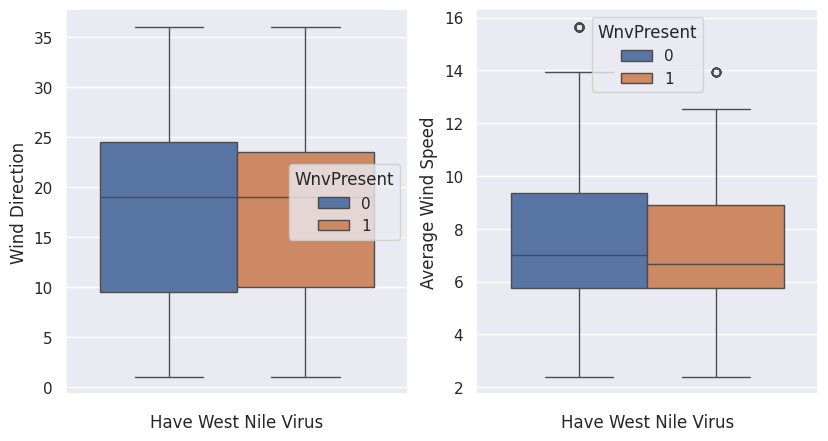

In [215]:
# Visualize 'Tavg', 'PrecipTotal', 'StnPressure', 'ResultDir', 'AvgSpeed'
# Correlated features -> 'Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel'

# Plot on WnvPresent
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
ax = sns.boxplot(train_and_weather, y='Tavg', hue='WnvPresent')
ax.set(xlabel='Have West Nile Virus', ylabel='Average Temperature')
plt.subplot(1, 3, 2)
ax = sns.boxplot(train_and_weather, y='PrecipTotal', hue='WnvPresent')
ax.set(xlabel='Have West Nile Virus', ylabel='Precipitation')
plt.subplot(1, 3, 3)
ax = sns.boxplot(train_and_weather, y='StnPressure', hue='WnvPresent')
ax.set(xlabel='Have West Nile Virus', ylabel='Pressure')
plt.show()

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
ax = sns.boxplot(train_and_weather, y='ResultDir', hue='WnvPresent')
ax.set(xlabel='Have West Nile Virus', ylabel='Wind Direction')
plt.subplot(1, 3, 2)
ax = sns.boxplot(train_and_weather, y='AvgSpeed', hue='WnvPresent')
ax.set(xlabel='Have West Nile Virus', ylabel='Average Wind Speed')
plt.show()

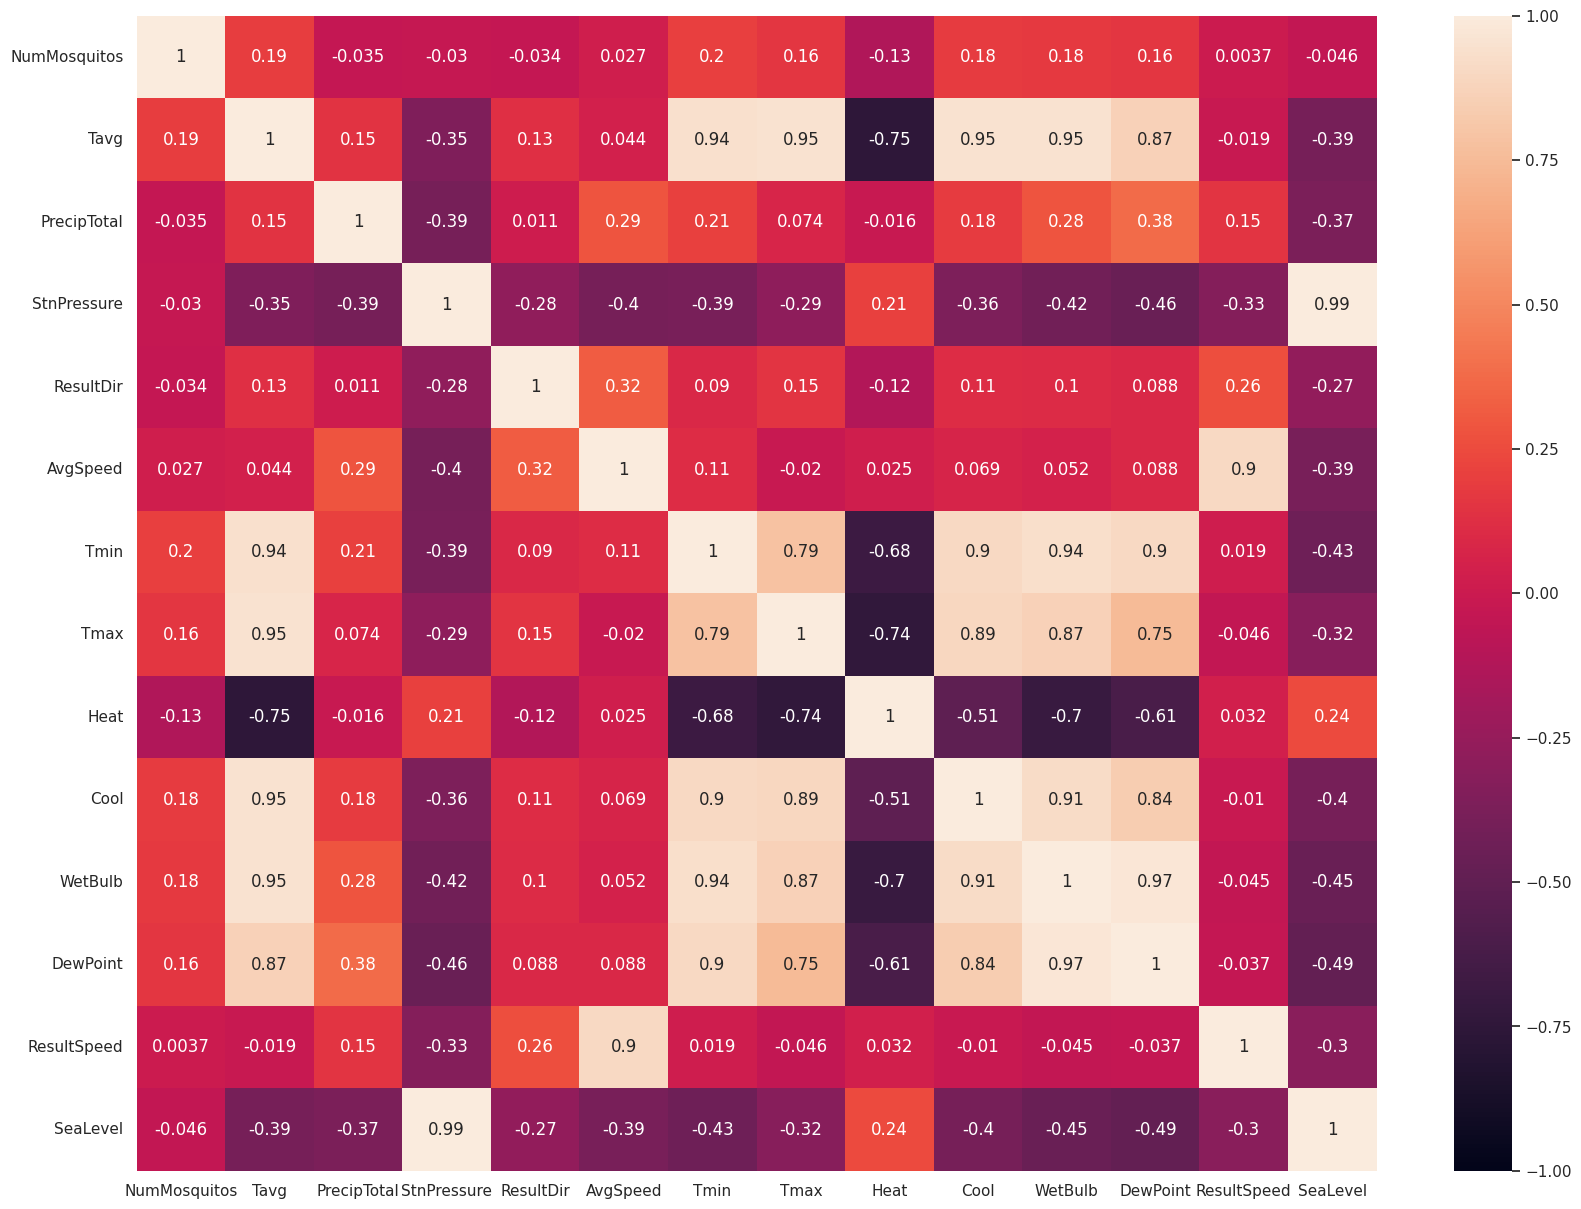

In [216]:
# Correlation with NumMosquitos
plt.figure(figsize=(20, 15))
sns.heatmap(train_and_weather[['NumMosquitos', 'Tavg', 'PrecipTotal', 'StnPressure', 'ResultDir', 'AvgSpeed', 'Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel']].corr(numeric_only=True), vmin=-1, vmax=1, annot=True);

## Map visualization

In [217]:
# Spray area
fig = px.scatter_mapbox(
    data_frame=spray_df,
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    color='Date',
    height=800, width=800,
    mapbox_style='open-street-map')

fig.show();

In [218]:
# Prepare plot data, number of mosquitos and WnvPresent over time
# Sum NumMosquitos and WnvPresent from multiple splitted record
animate_df = train_df.copy()
col = list(animate_df.drop(columns=['NumMosquitos', 'WnvPresent']).columns)
animate_df = animate_df.groupby(col, as_index=False)[['NumMosquitos', 'WnvPresent']].sum()

In [219]:
# Correcting WnvPresent values
animate_df['WnvPresent'] = animate_df['WnvPresent'].progress_map(lambda x: 0 if x == 0 else 1)

  0%|          | 0/8475 [00:00<?, ?it/s]

In [220]:
# Create year_month and year_week for visualization
animate_df['weeknum'] = animate_df['Date'].dt.strftime("%U").astype(int)
animate_df['year'] = animate_df['Date'].dt.year
animate_df['year_month'] = animate_df.progress_apply(lambda x: str(x['Date'].year) + str(x['Date'].month).zfill(2), axis=1)
animate_df['year_week'] = animate_df.progress_apply(lambda x: str(x['year']) + str(x['weeknum'] + x['weeknum']%2).zfill(2), axis=1)
animate_df

  0%|          | 0/8475 [00:00<?, ?it/s]

  0%|          | 0/8475 [00:00<?, ?it/s]

Date                                            Address  \
0    2007-05-29        1100 Roosevelt Road, Chicago, IL 60608, USA   
1    2007-05-29        1100 Roosevelt Road, Chicago, IL 60608, USA   
2    2007-05-29   1100 South Peoria Street, Chicago, IL 60608, USA   
3    2007-05-29   1100 West Chicago Avenue, Chicago, IL 60642, USA   
4    2007-05-29     1500 North Long Avenue, Chicago, IL 60651, USA   
...         ...                                                ...   
8470 2013-09-26        South Stony Island Avenue, Chicago, IL, USA   
8471 2013-09-26        South Stony Island Avenue, Chicago, IL, USA   
8472 2013-09-26           South Vincennes Avenue, Chicago, IL, USA   
8473 2013-09-26  University of Illinois at Chicago, 1100 South ...   
8474 2013-09-26          West Garfield Boulevard, Chicago, IL, USA   

                     Species  Block               Street  Trap  \
0     CULEX PIPIENS/RESTUANS     11          W ROOSEVELT  T048   
1             CULEX RESTUANS     11          W ROOSEVELT  T048   
2             CULEX RESTUANS     11          S PEORIA ST  T091   
3             CULEX RESTUANS     11            W CHICAGO  T049   
4             CULEX RESTUANS     15           N LONG AVE  T153   
...                      ...    ...                  ...   ...   
8470           CULEX PIPIENS     10   S STONY ISLAND AVE  T138   
8471  CULEX PIPIENS/RESTUANS     10   S STONY ISLAND AVE  T138   
8472  CULEX PIPIENS/RESTUANS     10          S VINCENNES  T089   
8473  CULEX PIPIENS/RESTUANS     11        S ASHLAND AVE  T090   
8474  CULEX PIPIENS/RESTUANS     90      W GARFIELD BLVD  T226   

                     AddressNumberAndStreet   Latitude  Longitude  \
0            1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224   
1            1100  W ROOSEVELT, Chicago, IL  41.867108 -87.654224   
2            1100  S PEORIA ST, Chicago, IL  41.862292 -87.648860   
3              1100  W CHICAGO, Chicago, IL  41.896282 -87.655232   
4             1500  N LONG AVE, Chicago, IL  41.907645 -87.760886   
...                                     ...        ...        ...   
8470  1000  S STONY ISLAND AVE, Chicago, IL  41.726465 -87.585413   
8471  1000  S STONY ISLAND AVE, Chicago, IL  41.726465 -87.585413   
8472         1000  S VINCENNES, Chicago, IL  41.723195 -87.649970   
8473       1100  S ASHLAND AVE, Chicago, IL  41.868077 -87.666901   
8474     9000  W GARFIELD BLVD, Chicago, IL  41.793818 -87.654234   

      AddressAccuracy  NumMosquitos  WnvPresent  weeknum  year year_month  \
0                   8             1           0       21  2007     200705   
1                   8             2           0       21  2007     200705   
2                   8             1           0       21  2007     200705   
3                   8             1           0       21  2007     200705   
4                   8             1           0       21  2007     200705   
...               ...           ...         ...      ...   ...        ...   
8470                5             6           0       38  2013     201309   
8471                5             4           0       38  2013     201309   
8472                5             4           0       38  2013     201309   
8473                9             2           0       38  2013     201309   
8474                5             8           0       38  2013     201309   

     year_week  
0       200722  
1       200722  
2       200722  
3       200722  
4       200722  
...        ...  
8470    201338  
8471    201338  
8472    201338  
8473    201338  
8474    201338  

[8475 rows x 16 columns]

In [221]:
# Plot number of mosquitos in traps with Wnv present or not
# print(spray_df['Date'].unique())

fig = px.scatter_mapbox(
    data_frame=animate_df,
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    hover_name='Species',
    size='NumMosquitos',
    color='WnvPresent',
    size_max=80,
    animation_frame='year_week',
    range_color=[0, 1],
    height=800, width=800,
    mapbox_style='open-street-map'
)

fig.show()

## Feature Engineering

### Weather rolling average

In [222]:
# Impute missing data (only 1 row)
display(weather_df_avg.isna().sum())
knn_imp = KNNImputer()
weather_df_avg['StnPressure'] = knn_imp.fit_transform(weather_df_avg[['StnPressure']])

Tmax           0
Tmin           0
Tavg           0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
PrecipTotal    0
StnPressure    1
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64

In [223]:
# Create weather rolling average dataframe
weather_df_rolling_avg = weather_df_avg.rolling('14D').mean().reset_index()

### Train data features
week of year, year and `count previous week records` per species & block in each year & week of year

In [224]:
# Extract weeknum, month and year
train_df['weeknum'] = train_df['Date'].dt.strftime("%U").astype(int)
train_df['year'] = train_df['Date'].dt.year
train_df['month'] = train_df['Date'].dt.month

In [225]:
# Function for counting previous week records until the current date in a row
def count_prev_week(row, df, weeks=1):
    filter_year = df['year'] == row['year']
    filter_weeknum = (df['weeknum'] >= row['weeknum'] - weeks) & (df['weeknum'] <= row['weeknum'] - 1)
    filter_species = df['Species'] == row['Species']
    filter_location = (df['Latitude'] == row['Latitude']) & (df['Longitude'] == row['Longitude'])

    return df[filter_year & filter_weeknum & filter_species & filter_location].count().values[0]

def count_current_week(row, df):
    filter_year = df['year'] == row['year']
    filter_weeknum = (df['weeknum'] == row['weeknum'])
    filter_species = df['Species'] == row['Species']
    filter_location = (df['Latitude'] == row['Latitude']) & (df['Longitude'] == row['Longitude'])

    return df[filter_year & filter_weeknum & filter_species & filter_location].count().values[0]

In [226]:
# Create current, previous week(s) records count
train_df['count_current_week_records'] = train_df.progress_apply(lambda row: count_prev_week(row, train_df), axis=1)
train_df['count_prev_week_records'] = train_df.progress_apply(lambda row: count_prev_week(row, train_df, 1), axis=1)
# train_df['count_prev_2week_records'] = train_df.progress_apply(lambda row: count_prev_week(row, train_df, 2), axis=1)

  0%|          | 0/10506 [00:00<?, ?it/s]

  0%|          | 0/10506 [00:00<?, ?it/s]

Create new dataframe, `block WnvPresent proportion` on each week and year

In [227]:
train_df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  weeknum  year  month  count_current_week_records  \
0             1           0       21  2007      5                           0   
1             1           0       21  2007      5                           0   
2             1           0       21  2007      5                           0   
3             1           0       21  2007      5                           0   
4             4           0       21  2007      5                           0   

   count_prev_week_records  
0                        0  
1                        0  
2                        0  
3                        0  
4                        0

In [228]:
# Count wnv_not_present records by species + location + week of year
temp_df = train_df.loc[train_df['WnvPresent'] == 0, ['Species', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']].groupby(['Species', 'Latitude', 'Longitude', 'weeknum', 'year'], as_index=False)['NumMosquitos'].count().rename(columns={'NumMosquitos': 'count_wnv_not_present'})
temp_df = temp_df.groupby(['Species', 'Latitude', 'Longitude', 'weeknum'], as_index=False)['count_wnv_not_present'].mean()

In [229]:
# Count wnv_present records by species + location + week of year
temp_df_2 = train_df.loc[train_df['WnvPresent'] == 1, ['Species', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'weeknum', 'year']].groupby(['Species', 'Latitude', 'Longitude', 'weeknum', 'year'], as_index=False)['NumMosquitos'].count().rename(columns={'NumMosquitos': 'count_wnv_present'})
temp_df_2 = temp_df_2.groupby(['Species', 'Latitude', 'Longitude', 'weeknum'], as_index=False)['count_wnv_present'].mean()

In [230]:
# Merge, prepare for creating wnv_present proportion dataframe
temp_df = temp_df.merge(right=temp_df_2, on=['Species', 'Latitude', 'Longitude', 'weeknum'], how='left').fillna(0)
temp_df

Species   Latitude  Longitude  weeknum  count_wnv_not_present  \
0     CULEX ERRATICUS  41.974689 -87.890615       35                    1.0   
1       CULEX PIPIENS  41.644612 -87.604498       30                    1.0   
2       CULEX PIPIENS  41.644612 -87.604498       31                    1.0   
3       CULEX PIPIENS  41.644612 -87.604498       32                    1.0   
4       CULEX PIPIENS  41.644612 -87.604498       33                    2.0   
...               ...        ...        ...      ...                    ...   
4474  CULEX TERRITANS  42.006858 -87.675919       38                    1.0   
4475  CULEX TERRITANS  42.010412 -87.662140       23                    1.0   
4476  CULEX TERRITANS  42.010412 -87.662140       30                    1.0   
4477  CULEX TERRITANS  42.011601 -87.811506       39                    1.0   
4478  CULEX TERRITANS  42.017430 -87.687769       33                    1.0   

      count_wnv_present  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0  
...                 ...  
4474                0.0  
4475                0.0  
4476                0.0  
4477                0.0  
4478                0.0  

[4479 rows x 6 columns]

In [231]:
# Create wnv_present proportion dataframe
# wnv_proportion_df = pd.DataFrame(temp_df.groupby(['Latitude', 'Longitude'])['count_wnv_present'].mean()/temp_df.groupby(['Latitude', 'Longitude'])['count_wnv_not_present'].mean(), columns=['wnv_present_proportion']).reset_index()
wnv_proportion_df = pd.DataFrame(temp_df.groupby(['Latitude', 'Longitude'])['count_wnv_present'].mean()/\
                                 (temp_df.groupby(['Latitude', 'Longitude'])['count_wnv_present'].mean() + temp_df.groupby(['Latitude', 'Longitude'])['count_wnv_not_present'].mean()),
                                 columns=['wnv_present_proportion']).reset_index()
wnv_proportion_df

Latitude  Longitude  wnv_present_proportion
0    41.644612 -87.604498                0.058824
1    41.659112 -87.538693                0.120000
2    41.662014 -87.724608                0.089054
3    41.673408 -87.599862                0.152443
4    41.678618 -87.559308                0.014252
..         ...        ...                     ...
133  42.008314 -87.777921                0.147783
134  42.009876 -87.807277                0.141176
135  42.010412 -87.662140                0.000000
136  42.011601 -87.811506                0.024390
137  42.017430 -87.687769                0.000000

[138 rows x 3 columns]

In [232]:
# temp_df = temp_df.merge(right=temp_df_2, on=['Species', 'Latitude', 'Longitude', 'weeknum'], how='outer')
# temp_df

In [233]:
# def calculate_wnv_present_proportion(row):
#     if not np.isnan(row['count_wnv_not_present']) and not np.isnan(row['count_wnv_present']):
#         return row['count_wnv_present'] / row['count_wnv_not_present']
#     elif np.isnan(row['count_wnv_present']):
#         return 0
#     else:
#         return 1

# wnv_proportion_df = temp_df.copy()
# wnv_proportion_df['wnv_present_proportion'] = temp_df.progress_apply(calculate_wnv_present_proportion, axis=1)
# wnv_proportion_df

In [234]:
# wnv_proportion_df_avg = wnv_proportion_df.groupby(['Latitude', 'Longitude'], as_index=False)['wnv_present_proportion'].mean()

In [235]:
# Merge into train_df
train_df = train_df.merge(right=wnv_proportion_df, on=['Latitude', 'Longitude'], how='left')
train_df.isna().sum()

Date                          0
Address                       0
Species                       0
Block                         0
Street                        0
Trap                          0
AddressNumberAndStreet        0
Latitude                      0
Longitude                     0
AddressAccuracy               0
NumMosquitos                  0
WnvPresent                    0
weeknum                       0
year                          0
month                         0
count_current_week_records    0
count_prev_week_records       0
wnv_present_proportion        0
dtype: int64

`Spatial feature` - count of neighbour blocks records

In [236]:
# Check neighbour blocks
# from geopy import distance

# all_locs = pd.DataFrame(columns=['Latitude', 'Longitude', 'neighbour_loc'])
# all_locs[['Latitude', 'Longitude']] = pd.concat([train_df[['Latitude', 'Longitude']].drop_duplicates(), test_df[['Latitude', 'Longitude']].drop_duplicates()]).drop_duplicates()
# all_locs.reset_index(inplace=True)

# def find_neighbour_block(row):
#     block_location = (row['Latitude'], row['Longitude'])

#     dist_from_block = all_locs.copy()
#     dist_from_block['dist'] = dist_from_block.progress_apply(lambda x: distance.distance(block_location, (x['Latitude'], x['Longitude'])).m, axis=1)

#     return list(dist_from_block[(dist_from_block['dist'] <= 1000) & (dist_from_block['Latitude'] != row['Latitude']) & (dist_from_block['Longitude'] != row['Longitude'])]['index'].unique())

# all_locs['neighbour_loc'] = all_locs.drop_duplicates().progress_apply(find_neighbour_block, axis=1)

In [237]:
# all_locs.head()

In [238]:
# all_locs[['index', 'Latitude', 'Longitude']].groupby('index').count()

In [239]:
# Function for counting previous week records of neighbour locations
# def count_prev_week_neighbour(row, df, weeks=1):
#     loc_ids = all_locs[(all_locs['Latitude'] == row['Latitude']) & (all_locs['Longitude'] == row['Longitude'])]['index'].values[0]
#     neighbour_loc = all_locs[(all_locs['Latitude'] == row['Latitude']) & (all_locs['Longitude'] == row['Longitude'])]['neighbour_loc'].values[0]
#     count_neighbour_records = 0

#     filter_year = df['year'] == row['year']
#     filter_weeknum = (df['weeknum'] == row['weeknum'] - weeks)
#     for loc in neighbour_loc:
#         filter_location = (df['Latitude'] == all_locs[all_locs['index'] == loc_ids]['Latitude'].values[0]) & (df['Longitude'] == all_locs[all_locs['index'] == loc_ids]['Longitude'].values[0])
#         count_neighbour_records += df[filter_year & filter_weeknum & filter_location].count().values[0]

#     return count_neighbour_records

In [240]:
# Create previous week(s) neighbour records count
# train_df['count_prev_week_neighbour_records'] = train_df.progress_apply(lambda row: count_prev_week_neighbour(row, train_df, 1), axis=1)
# train_df['count_prev_2week_neighbour_records'] = train_df.progress_apply(lambda row: count_prev_week_neighbour(row, train_df, 2), axis=1)
# train_df.head()

In [241]:
# Create new feature, count_current_week_diff, count_prev_week_diff and count_prev_week_neighbour_records diff
train_df.set_index('Date', inplace=True)
train_df['count_current_week_diff'] = train_df['count_current_week_records'].diff()
train_df['count_prev_week_diff'] = train_df['count_prev_week_records'].diff()
# train_df['count_prev_week_neighbour_diff'] = train_df['count_prev_week_neighbour_records'].diff()
train_df.fillna(0, inplace=True)
train_df.reset_index(inplace=True)
train_df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   NumMosquitos  WnvPresent  weeknum  year  month  count_current_week_records  \
0             1           0       21  2007      5                           0   
1             1           0       21  2007      5                           0   
2             1           0       21  2007      5                           0   
3             1           0       21  2007      5                           0   
4             4           0       21  2007      5                           0   

   count_prev_week_records  wnv_present_proportion  count_current_week_diff  \
0                        0                0.164467                      0.0   
1                        0                0.164467                      0.0   
2                        0                0.000000                      0.0   
3                        0                0.031250                      0.0   
4                        0                0.031250                      0.0   

   count_prev_week_diff  
0                   0.0  
1                   0.0  
2                   0.0  
3                   0.0  
4                   0.0

## Modelling

### Evaluate function

In [242]:
def evaluate(model, X_train, X_test, y_train, y_test):
    pred_test = model.predict(X_test)
    probs_train = model.predict_proba(X_train)[:,1]
    probs_test = model.predict_proba(X_test)[:,1]
    auc_train = round(roc_auc_score(y_train, probs_train), 4)
    auc_test = round(roc_auc_score(y_test, probs_test), 4)
    fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)

    # Score
    cv = StratifiedKFold()
    print('Cv score (accuracy):', cross_val_score(model, X_train, y_train, cv=cv).mean())
    print('Recall:', recall_score(y_test, pred_test))

    # plot
    plt.figure(figsize=(12, 5))
    
    # confusion matrix
    ax = plt.subplot(1, 2, 1)
    ConfusionMatrixDisplay(confusion_matrix(y_test, pred_test)).plot(ax=ax)
    plt.grid(False); plt.title('Confusion Matrix for test')

    # ROC curve
    ax = plt.subplot(1, 2, 2)
    RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=auc_train).plot(ax=ax, name='train')
    RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=auc_test).plot(ax=ax, name='test')
    plt.plot((0,1), (0,1)); plt.title(f'ROC curve (AUC: {auc_test})')
    plt.show()

### Join train data with weather rolling average

In [243]:
# Convert date to datetime'
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [244]:
# Feature selection

# 'Latitude', 'Longitude', 'weeknum', 'year', 'month', 'Tavg', 'PrecipTotal', 'StnPressure', 'ResultDir', 'AvgSpeed'
# Correlate weather features -> 'Tmin', 'Tmax', 'Heat', 'Cool', 'WetBulb', 'DewPoint', 'ResultSpeed', 'SeaLevel'
# Best -> ['Latitude', 'Longitude', 'weeknum', 'year', 'Tavg', 'AvgSpeed']
num_features = ['Latitude', 'Longitude', 'weeknum', 'year', 'Tavg', 'AvgSpeed']

# These columns will be dummified
# 'Species', 'Block'
cat_features = ['Species']

# 'count_prev_week_records', 'count_prev_week_diff', 'count_prev_week_records', 'count_prev_2week_records', 'wnv_present_proportion', 'species_can_have_wnv', 'count_prev_week_neighbour_records', 'count_prev_2week_neighbour_records', 'count_prev_week_diff', 'count_prev_week_neighbour_diff'
# Best for Lr -> ['count_prev_week_diff', 'count_prev_week_records', 'wnv_present_proportion']
# Best for XGBoost -> ['count_prev_week_diff', 'count_prev_week_records']
eng_features = ['count_current_week_diff', 'count_prev_week_diff', 'wnv_present_proportion']

# weather_df_avg, weather_df_rolling_avg
weather_for_merge = weather_df_rolling_avg

In [245]:
# Merge train & weather rolling avg
combined_df = train_df.merge(
    right=weather_for_merge,
    on='Date'
)

combined_df.head()

Date                                            Address  \
0 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
1 2007-05-29  4100 North Oak Park Avenue, Chicago, IL 60634,...   
2 2007-05-29  6200 North Mandell Avenue, Chicago, IL 60646, USA   
3 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   
4 2007-05-29    7900 West Foster Avenue, Chicago, IL 60656, USA   

                  Species  Block           Street  Trap  \
0  CULEX PIPIENS/RESTUANS     41   N OAK PARK AVE  T002   
1          CULEX RESTUANS     41   N OAK PARK AVE  T002   
2          CULEX RESTUANS     62    N MANDELL AVE  T007   
3  CULEX PIPIENS/RESTUANS     79     W FOSTER AVE  T015   
4          CULEX RESTUANS     79     W FOSTER AVE  T015   

              AddressNumberAndStreet   Latitude  Longitude  AddressAccuracy  \
0  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
1  4100  N OAK PARK AVE, Chicago, IL  41.954690 -87.800991                9   
2   6200  N MANDELL AVE, Chicago, IL  41.994991 -87.769279                9   
3    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   
4    7900  W FOSTER AVE, Chicago, IL  41.974089 -87.824812                8   

   ...   DewPoint    WetBulb      Heat  Cool  PrecipTotal  StnPressure  \
0  ...  45.357143  54.357143  3.571429  3.25     0.068321    29.434286   
1  ...  45.357143  54.357143  3.571429  3.25     0.068321    29.434286   
2  ...  45.357143  54.357143  3.571429  3.25     0.068321    29.434286   
3  ...  45.357143  54.357143  3.571429  3.25     0.068321    29.434286   
4  ...  45.357143  54.357143  3.571429  3.25     0.068321    29.434286   

    SeaLevel  ResultSpeed  ResultDir  AvgSpeed  
0  30.121429     8.021429  16.214286  9.682143  
1  30.121429     8.021429  16.214286  9.682143  
2  30.121429     8.021429  16.214286  9.682143  
3  30.121429     8.021429  16.214286  9.682143  
4  30.121429     8.021429  16.214286  9.682143  

[5 rows x 33 columns]

In [246]:
X = pd.get_dummies(combined_df[num_features + cat_features + eng_features], columns=cat_features, drop_first=True)
y = combined_df['WnvPresent']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [247]:
# Scale & Oversampling
from imblearn.over_sampling import SMOTE

ss = StandardScaler()
sm = SMOTE(random_state=42)

X_train_sc = ss.fit_transform(X_train)
Xsm_train, ysm_train = sm.fit_resample(X_train_sc, y_train)
# Xsm_train, ysm_train = X_train_sc, y_train

In [248]:
# Scale validation set
X_val_sc = ss.transform(X_val)

### Logistic Regression

Cv score (accuracy): 0.7333236612953968
Recall: 0.7463768115942029


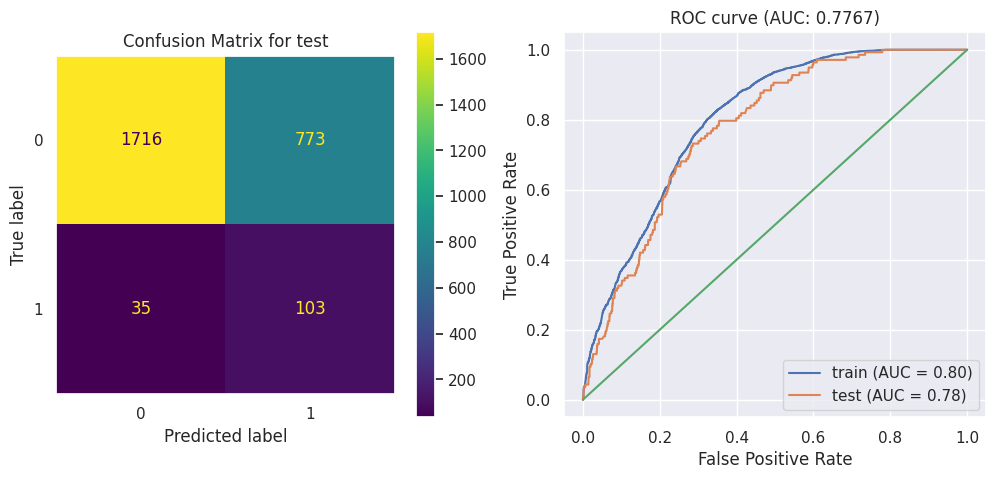

In [266]:
lr = LogisticRegression(max_iter=1000)
lr.fit(Xsm_train, ysm_train)
evaluate(lr, Xsm_train, X_val_sc, ysm_train, y_val)

Get predict actual WnvPresent and predict proba for the `cost-benefit` analysis

In [250]:
wnv_proba_df = pd.concat([y_val.reset_index(drop=True), pd.DataFrame(lr.predict_proba(X_val_sc)[:, 1], columns=['Proba'])], axis=1)
display(wnv_proba_df)
wnv_proba_df.to_csv('../data/cost_effective_analysis/wnv_proba.csv', index=False)

WnvPresent     Proba
0              0  0.479737
1              0  0.574828
2              0  0.402885
3              0  0.134319
4              0  0.634825
...          ...       ...
2622           0  0.000087
2623           0  0.037930
2624           0  0.499571
2625           0  0.739531
2626           0  0.662171

[2627 rows x 2 columns]

### Random Forest

Cv score (accuracy): 0.8921779822409723
Recall: 0.5579710144927537


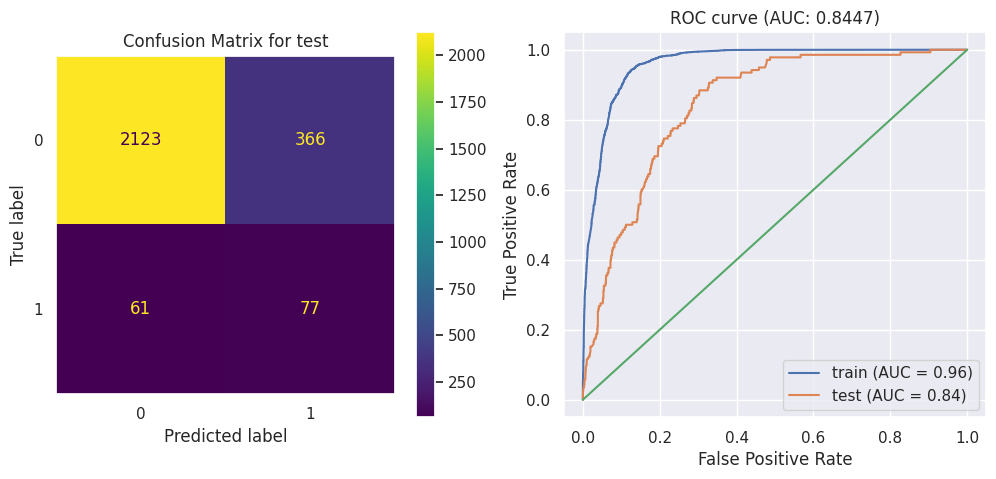

In [251]:
rf = RandomForestClassifier(max_depth=8)
rf.fit(Xsm_train, ysm_train)
evaluate(rf, Xsm_train, X_val_sc, ysm_train, y_val)

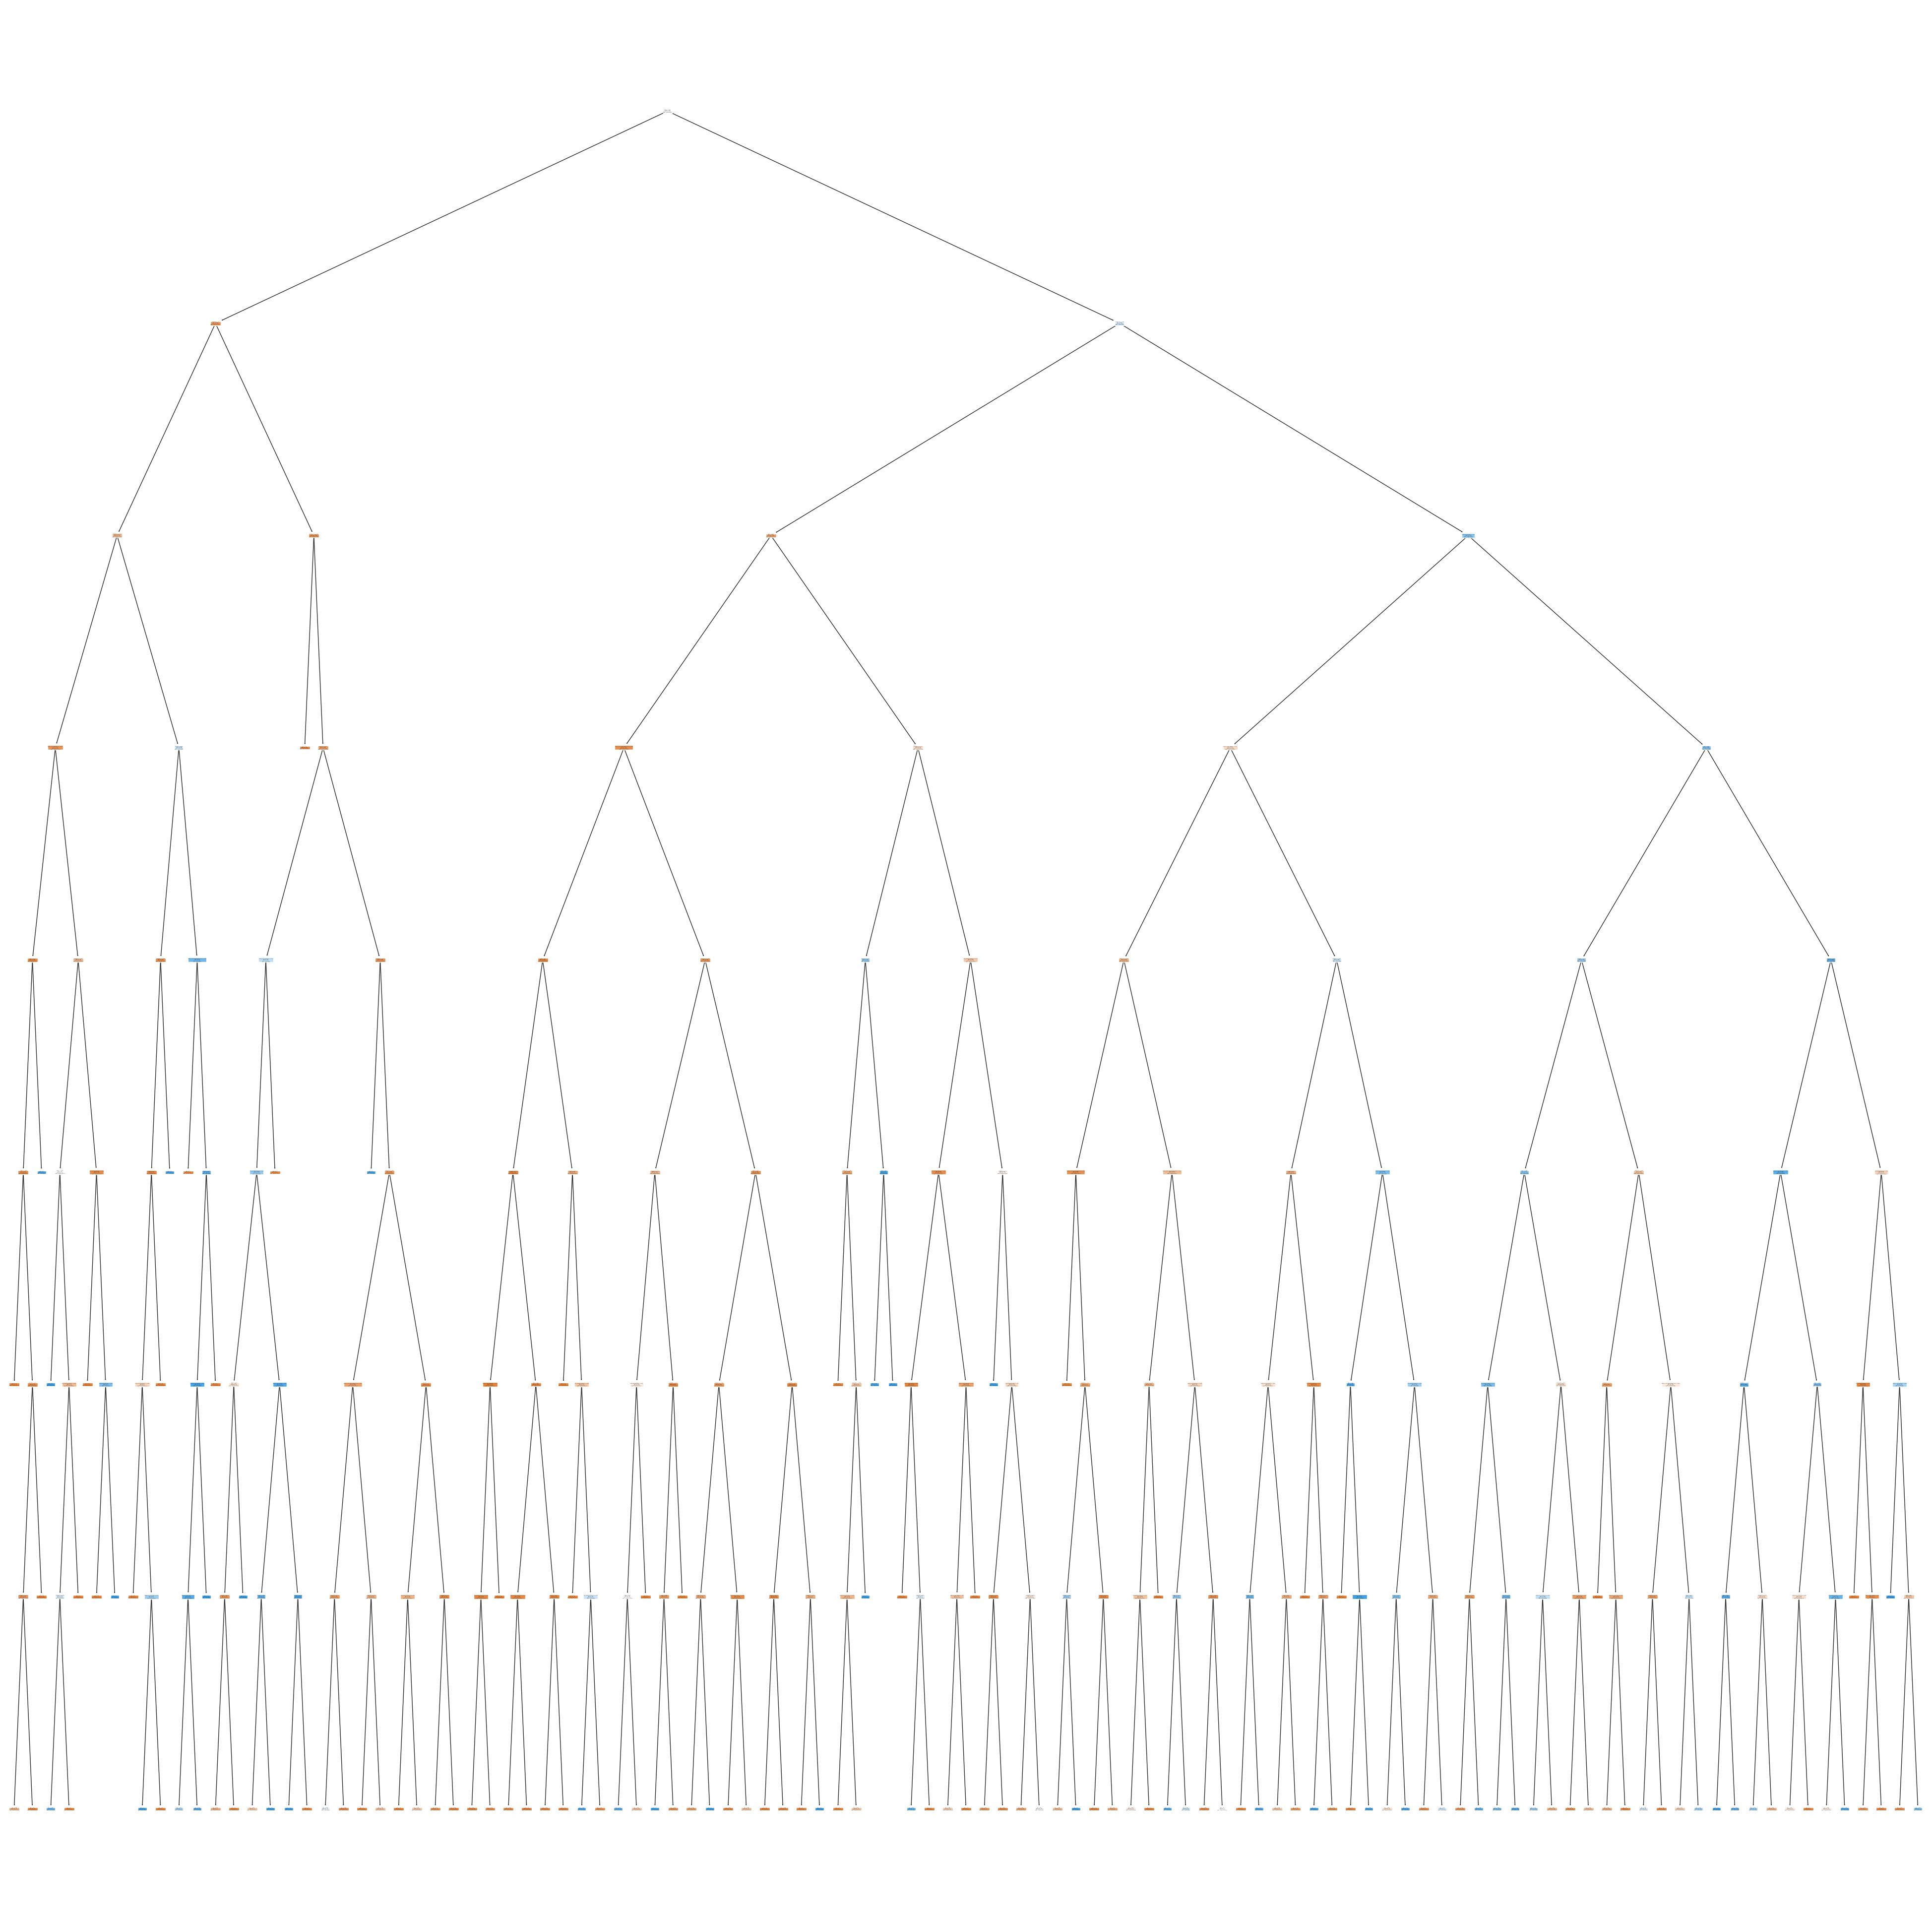

In [252]:
# 1st tree
from sklearn.tree import plot_tree

plt.figure(figsize=(50, 50))
plot_tree(rf.estimators_[0], feature_names=list(X_train.columns),
          class_names=['Wnv Not Present', 'Wnv Present'], filled=True);

### XGBoost

Cv score (accuracy): 0.7892435651610203
Recall: 0.7536231884057971


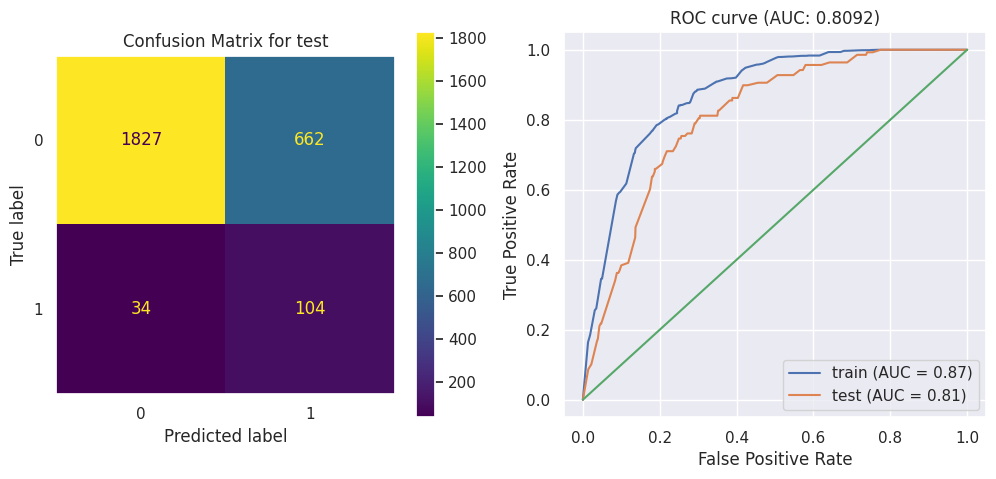

In [253]:
xgb = XGBClassifier(max_depth=1, n_estimators=15)
xgb.fit(Xsm_train, ysm_train)
evaluate(xgb, Xsm_train, X_val_sc, ysm_train, y_val)

### RGF

Cv score (accuracy): 0.9036308262349619
Recall: 0.5289855072463768


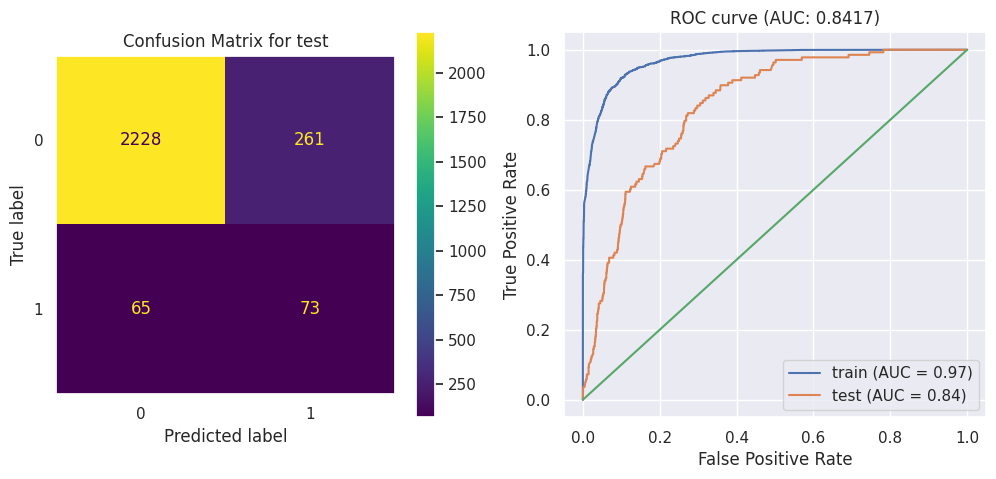

In [254]:
rgf = RGFClassifier()
rgf.fit(Xsm_train, ysm_train)
evaluate(rgf, Xsm_train, X_val_sc, ysm_train, y_val)

### Retrain with full dataset

In [255]:
X_sc = ss.fit_transform(X)
Xsm, ysm = sm.fit_resample(X_sc, y)
# Xsm, ysm = X_sc, y

lr.fit(Xsm, ysm)
rf.fit(Xsm, ysm)
xgb.fit(Xsm, ysm)
rgf.fit(Xsm, ysm)

RGFClassifier()

### Check Logistic Regression Coef

In [256]:
pd.DataFrame(np.exp(lr.coef_ / ss.scale_), columns=X.columns).T.rename(columns={0: 'Coef'})

Coef
Latitude                            0.584258
Longitude                           0.142960
weeknum                             1.195539
year                                1.197124
Tavg                                1.147783
AvgSpeed                            0.620912
count_current_week_diff             1.009184
count_prev_week_diff                1.009184
wnv_present_proportion          20784.669510
Species_CULEX PIPIENS               6.262973
Species_CULEX PIPIENS/RESTUANS      4.231754
Species_CULEX RESTUANS              1.525381
Species_CULEX SALINARIUS            0.002671
Species_CULEX TARSALIS              0.003241
Species_CULEX TERRITANS             0.002452

## Submission

In [257]:
# Preprocess data
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['weeknum'] = test_df['Date'].dt.strftime("%U").astype(int)
test_df['year'] = test_df['Date'].dt.year
test_df['month'] = test_df['Date'].dt.month

# Count prev week records & calculate wnv proportion
# somehow, using counts from train data gives the better score
test_df['count_current_week_records'] = test_df.progress_apply(lambda row: count_prev_week(row, train_df), axis=1)
test_df['count_prev_week_records'] = test_df.progress_apply(lambda row: count_prev_week(row, train_df, 1), axis=1)
# test_df['count_prev_2week_records'] = test_df.progress_apply(lambda row: count_prev_week_neighbour(row, train_df, 2), axis=1)
# test_df['count_prev_week_neighbour_records'] = test_df.progress_apply(lambda row: count_prev_week_neighbour(row, train_df, 1), axis=1)
# test_df['count_prev_2week_neighbour_records'] = test_df.progress_apply(lambda row: count_prev_week_neighbour(row, train_df, 2), axis=1)
test_df = test_df.merge(right=wnv_proportion_df, on=['Latitude', 'Longitude'], how='left').fillna(0)

# Calculate count prev week records diff
test_df.set_index('Date', inplace=True)
test_df['count_current_week_diff'] = test_df['count_current_week_records'].diff()
test_df['count_prev_week_diff'] = test_df['count_prev_week_records'].diff()
# test_df['count_prev_week_neighbour_diff'] = test_df['count_prev_week_neighbour_records'].diff()
test_df.fillna(0, inplace=True)
test_df.reset_index(inplace=True)

# Prepare Date for next joining
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df.isna().sum()

  0%|          | 0/116293 [00:00<?, ?it/s]

  0%|          | 0/116293 [00:00<?, ?it/s]

Date                          0
Id                            0
Address                       0
Species                       0
Block                         0
Street                        0
Trap                          0
AddressNumberAndStreet        0
Latitude                      0
Longitude                     0
AddressAccuracy               0
weeknum                       0
year                          0
month                         0
count_current_week_records    0
count_prev_week_records       0
wnv_present_proportion        0
count_current_week_diff       0
count_prev_week_diff          0
dtype: int64

In [258]:
# Fill null with mean
# test_df.fillna(wnv_proportion_df_avg[['wnv_present_proportion']].mean(), inplace=True)
# test_df.isna().sum()

In [259]:
# Join with weather rolling average
combined_test_df = test_df.merge(
    right=weather_for_merge,
    on='Date'
)

In [260]:
# Check null value
combined_test_df.isna().sum()

Date                          0
Id                            0
Address                       0
Species                       0
Block                         0
Street                        0
Trap                          0
AddressNumberAndStreet        0
Latitude                      0
Longitude                     0
AddressAccuracy               0
weeknum                       0
year                          0
month                         0
count_current_week_records    0
count_prev_week_records       0
wnv_present_proportion        0
count_current_week_diff       0
count_prev_week_diff          0
Tmax                          0
Tmin                          0
Tavg                          0
DewPoint                      0
WetBulb                       0
Heat                          0
Cool                          0
PrecipTotal                   0
StnPressure                   0
SeaLevel                      0
ResultSpeed                   0
ResultDir                     0
AvgSpeed

In [261]:
X_test = pd.get_dummies(combined_test_df[num_features + cat_features + eng_features], columns=cat_features, drop_first=True)

# Align
X_test, _ = X_test.align(pd.DataFrame(Xsm, columns=X_train.columns), join='right', axis=1, fill_value=0)

# Scale
X_test_sc = ss.transform(X_test)

In [262]:
# prediction_lr = pd.DataFrame(lr.pre(X_test_sc), columns=['WnvPresent'])
# prediction_rf = pd.DataFrame(rf.predict(X_test_sc), columns=['WnvPresent'])
# prediction_xgb = pd.DataFrame(xgb.predict(X_test_sc), columns=['WnvPresent'])

# Use predict proba
prediction_lr = pd.DataFrame(lr.predict_proba(X_test_sc)[:, 1], columns=['WnvPresent'])
prediction_rf = pd.DataFrame(rf.predict_proba(X_test_sc)[:, 1], columns=['WnvPresent'])
prediction_xgb = pd.DataFrame(xgb.predict_proba(X_test_sc)[:, 1], columns=['WnvPresent'])
prediction_rgf = pd.DataFrame(rgf.predict_proba(X_test_sc)[:, 1], columns=['WnvPresent'])

In [263]:
# pd.concat([test_df['Id'], prediction_lr], axis=1).to_csv('../submission/submission_lr.csv', index=False)
# pd.concat([test_df['Id'], prediction_rf], axis=1).to_csv('../submission/submission_rf.csv', index=False)
# pd.concat([test_df['Id'], prediction_xgb], axis=1).to_csv('../submission/submission_xgb.csv', index=False)
# pd.concat([test_df['Id'], prediction_rgf], axis=1).to_csv('../submission/submission_rgf.csv', index=False)